# **Trabalho \#1**: Deep Learning MO434/MC934
Universidade Estadual de Campinas (UNICAMP), Instituto de Computação (IC)

Profa. Sandra Avila, 2020s2





In [3]:
print('RA: 265680' + ' Felipe Marinho Tavares')

RA: 265680 Felipe Marinho Tavares


## Objetivo

Treinar e explorar o comportamento de diferentes componentes que integram uma **Rede Neural Convolucional (CNN)**, usando um subconjunto do dataset de lesões de pele ISIC Challenge 2017, classificando lesões malignas × benignas.

## Dataset

O dataset ISIC Challenge 2017 contém 2.000 imagens com 3 diagnósticos de lesão: nevos, ceratose seborreica e melanoma. Dessas, apenas melanoma é maligna. 

Para este trabalho vamos considerar apenas a **classificação binária** de malignas × benignas. Utilize o conjunto de validação para avaliar seus experimentos intermediários, e apenas no fim, use o teste. Informações sobre o dataset estão disponíveis em https://challenge.isic-archive.com/landing/2017/44.

A métrica oficial da base de dados é a AUC (_Area Under the ROC Curve_).

## Deadline

Segunda-feira, 7 de Dezembro 14h (antes da aula). 

Política de penalidade para submissões atrasadas: Você não está sendo encorajada(o) a submeter trabalho depois da data de submissão. Entretanto, caso isso aconteça, a nota será penalizada da seguinte forma:
- 8 de Dezembro 14h : nota * 0,75
- 9 de Dezembro 14h : nota * 0,5
- 10 de Dezembro 14h : nota * 0,25


## Submissão

Submeta o Jupyter Notebook (em Português ou Inglês) no Google Classroom.

**O trabalho NÃO é individual, deve ser feito em dupla.**

## Carregamento dos Dados

Os .zips contendo o dataset está no google drive. O código abaixo faz o download, e extrai o zip. Note que você precisará logar no Google para que esse processo seja possível. Caso haja alguma falha ou erro no processo, reinicie o notebook, e tente novamente.

Depois desse processo, teremos no diretório:

*   isic2017-train: 2000 imagens. 
*   isic2017-val:    150 imagens.
*   isic2017-test:   650 imagens.

In [1]:
!pip install PyDrive &> /dev/null

In [2]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

downloaded = drive.CreateFile({'id':"1EH2tlRi4Iqq8WfLOXl6hMc5jTeiIRzaW"})
downloaded.GetContentFile('isic2017-trainval.zip')
!unzip -q isic2017-trainval.zip

downloaded = drive.CreateFile({'id':"1uP1tCj6-T2FXxk7g7gqoC_SGOhqIQyrM"})   
downloaded.GetContentFile('isic2017-test.zip')       
!unzip -q isic2017-test.zip

Em cada diretório, temos uma pasta contendo as lesões benignas ('/benign') e outra contendo as lesões malignas ('/malignant'). A separação dessa forma facilita a importação dos dados utilizando o keras.

Note que o conjunto é altamente desbalanceado. Talvez seja adequado aplicar aumentação de dados nas imagens.

Para aumentação de dados, recomenda-se o uso da ImageDataGenerator do Keras, pois ela facilita o uso de aumentação e pré-processamento dos dados.


## Atividades

1. (1,0) Construa uma rede neural convolucional para baseline. Sugestão: comece por uma arquitetura simples. Quanto mais simples, melhor.


In [4]:
from glob import glob
import gc
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import PIL
import PIL.Image
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, regularizers

print(f"tensorflow version {tf.__version__}")

def def_seeds():
  np.random.seed(42)
  try:
    tf.random.set_seed(42)
  except:
    tf.set_random_seed(42)

def_seeds()
img_width, img_height = PIL.Image.open(glob("isic2017-train/benign/*")[0]).size
channels=3
batch_size=64

tensorflow version 2.4.0


In [5]:
# load train np.arrays

x_train_benign = np.asarray([np.array(PIL.Image.open(file_path)) for file_path in glob("isic2017-train/benign/*")])
y_train_benign = np.zeros(x_train_benign.shape[0])

x_train_malignant = np.asarray([np.array(PIL.Image.open(file_path)) for file_path in glob("isic2017-train/malignant/*")])
y_train_malignant = np.ones(x_train_malignant.shape[0])

x_train = tf.cast(np.vstack((x_train_benign, x_train_malignant)), tf.float32)
y_train = tf.cast(np.concatenate((y_train_benign, y_train_malignant)), tf.float32)

# load val np.arrays

x_val_benign = np.asarray([np.array(PIL.Image.open(file_path)) for file_path in glob("isic2017-val/benign/*")])
y_val_benign = np.zeros(x_val_benign.shape[0])

x_val_malignant = np.asarray([np.array(PIL.Image.open(file_path)) for file_path in glob("isic2017-val/malignant/*")])
y_val_malignant = np.ones(x_val_malignant.shape[0])

x_val = tf.cast(np.vstack((x_val_benign, x_val_malignant)), tf.float32)
y_val = tf.cast(np.concatenate((y_val_benign, y_val_malignant)), tf.float32)

# load test np.arrays

x_test_benign = np.asarray([np.array(PIL.Image.open(file_path)) for file_path in glob("isic2017-test/benign/*")])
y_test_benign = np.zeros(x_test_benign.shape[0])

x_test_malignant = np.asarray([np.array(PIL.Image.open(file_path)) for file_path in glob("isic2017-test/malignant/*")])
y_test_malignant = np.ones(x_test_malignant.shape[0])

x_test = tf.cast(np.vstack((x_test_benign, x_test_malignant)), tf.float32)
y_test = tf.cast(np.concatenate((y_test_benign, y_test_malignant)), tf.float32)

# ImageDataGenerator for data augmentation was not used due to tf problems with generators used with
# model.Sequential.fit() method causing memory leakage

In [6]:
## Get class_weights for model training in the imbalanced dataset

class_weights = {0: (1 / np.sum(y_train == 0)) * len(y_train) / 2.0,
                 1: (1 / np.sum(y_train == 1)) * len(y_train) / 2.0}
display("Class weights:", f"0: {class_weights[0]}", f"1: {class_weights[1]}")

'Class weights:'

'0: 0.6150061500615006'

'1: 2.6737967914438503'

In [7]:
# Baseline model

baseline_model = tf.keras.Sequential([
  layers.experimental.preprocessing.Rescaling(scale=1./255),
  layers.Conv2D(64, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(1, activation='sigmoid')
])

baseline_model.build((None, 299, 299, 3))
baseline_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling (Rescaling)        (None, 299, 299, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 297, 297, 64)      1792      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 148, 148, 64)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 146, 146, 32)      18464     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 73, 73, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 71, 71, 32)        9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 35, 35, 32)        0

In [8]:
def plot_metrics(history):
  mpl.rcParams['figure.figsize'] = (20, 8)
  colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
  
  metrics = ['loss', 'auc', 'prec', 'rec']
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(2,2,n+1)
    plt.plot(history.epoch, history.history[metric], color=colors[0], label='Train')
    plt.plot(history.epoch, history.history['val_'+metric],
             color=colors[0], linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    elif metric == 'auc':
      plt.ylim([0,1])
    else:
      plt.ylim([0,1])
    plt.legend()

  best_model_val = np.argmin(history.history['val_loss'])
  display("Best model in val (lower val_loss)")
  display(f"epoch: {best_model_val}")
  for metric in metrics:
    display(f"val_{metric}: {history.history[f'val_{metric}'][best_model_val]}")
  plt.show()

In [9]:
def train(model, loss="binary_crossentropy", opt="adam", epochs=60,
          tag="best"):
  """ Generic train function to call for models in this notebook. """
  mc = tf.keras.callbacks.ModelCheckpoint(f'{tag}_model.h5', monitor='val_loss', mode='min', verbose=1)
  es = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                        mode='min',
                                        verbose=1,
                                        patience=30,
                                        restore_best_weights=True)
  
  cb_list = [mc, es]

  metrics = [
        keras.metrics.TruePositives(name='tp'),
        keras.metrics.FalsePositives(name='fp'),
        keras.metrics.TrueNegatives(name='tn'),
        keras.metrics.FalseNegatives(name='fn'), 
        keras.metrics.BinaryAccuracy(name='acc'),
        keras.metrics.Precision(name='prec'),
        keras.metrics.Recall(name='rec'),
        keras.metrics.AUC(name='auc'),
  ]

  model.compile(
    optimizer=opt,
    loss=loss,
    metrics=metrics)
  
  history = model.fit(x_train, y_train, validation_data=(x_val, y_val),
                      epochs=epochs,
                      class_weight=class_weights,
                      callbacks=cb_list)
  return history

Epoch 1/60
63/63 [==============================] - 17s 123ms/step - loss: 0.6932 - tp: 105.6094 - fp: 416.7031 - tn: 427.0938 - fn: 89.5938 - acc: 0.5574 - prec: 0.1887 - rec: 0.4687 - auc: 0.5129 - val_loss: 0.6936 - val_tp: 30.0000 - val_fp: 120.0000 - val_tn: 0.0000e+00 - val_fn: 0.0000e+00 - val_acc: 0.2000 - val_prec: 0.2000 - val_rec: 1.0000 - val_auc: 0.5333

Epoch 00001: saving model to baseline_model.h5
Epoch 2/60
63/63 [==============================] - 6s 96ms/step - loss: 0.6804 - tp: 78.1094 - fp: 363.4219 - tn: 485.0938 - fn: 112.3750 - acc: 0.4553 - prec: 0.1723 - rec: 0.5388 - auc: 0.4921 - val_loss: 0.6931 - val_tp: 1.0000 - val_fp: 5.0000 - val_tn: 115.0000 - val_fn: 29.0000 - val_acc: 0.7733 - val_prec: 0.1667 - val_rec: 0.0333 - val_auc: 0.5000

Epoch 00002: saving model to baseline_model.h5
Epoch 3/60
63/63 [==============================] - 6s 97ms/step - loss: 0.6939 - tp: 100.5312 - fp: 481.5000 - tn: 363.5625 - fn: 93.4062 - acc: 0.4019 - prec: 0.1671 - rec: 0

'Best model in val (lower val_loss)'

'epoch: 6'

'val_loss: 0.6882274150848389'

'val_auc: 0.47138887643814087'

'val_prec: 0.0'

'val_rec: 0.0'

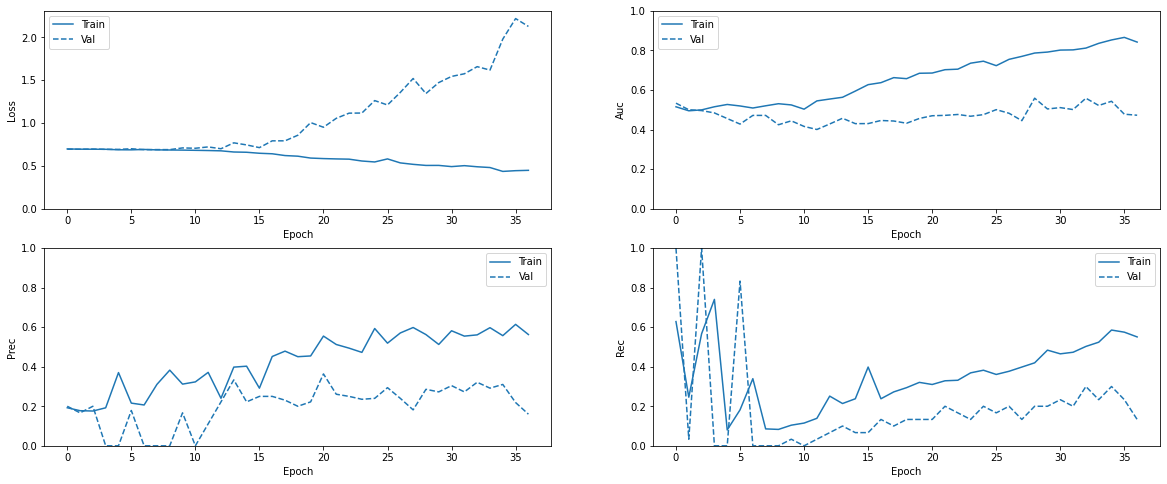

In [10]:
# Train baseline model and plot metrics from training

baseline_history = train(baseline_model, tag="baseline")
plot_metrics(baseline_history)

In [23]:
model = tf.keras.models.load_model("baseline_model.h5")
val_results = list(zip(model.metrics_names, model.evaluate(x_val, y_val)))
print("validation results:")
[print(each) for each in val_results];

5/5 [==============================] - 1s 36ms/step - loss: 2.1272 - tp: 4.0000 - fp: 21.0000 - tn: 99.0000 - fn: 26.0000 - acc: 0.6867 - prec: 0.1600 - rec: 0.1333 - auc: 0.4724
validation results:
('loss', 2.1271750926971436)
('tp', 4.0)
('fp', 21.0)
('tn', 99.0)
('fn', 26.0)
('acc', 0.6866666674613953)
('prec', 0.1599999964237213)
('rec', 0.13333334028720856)
('auc', 0.47236108779907227)



> Quais são as suas impressões? Arquitetura simples demais? Problema difícil demais? Poucos dados? (1-2 parágrafos)

The baseline model with `47K` parameters was capable to learn from the available dataset to an extent. During training, the best model was achieved in the epoch `6` with AUC `0.47`, as "best" in this case is considered the model weights with lower validation loss. It's possible to say the results are definitively not impressive for a deployment/solution but it can serve well as the performance for a baseline model.

To improve results, a bigger model could be used (more layers, bigger feature maps during convolutions) as more data, real or augmented, for training (desirably balanced) would probably result in better performance metrics.


2. (3,0) Explore o impacto de variar a quantidade de camadas de convolução e pooling, funções de ativação, inicializações e regularizações. Cuidado com overfitting! Explore, no mínimo, duas arquiteturas diferentes do baseline.

In [11]:
acts = ["relu", "elu", "tanh"]

optimizers = ["adam", "adagrad", "RMSprop"]
optimizers_str = ["adam", "adagrad", "RMSprop"]

regularization = [None, regularizers.l2(0.001), regularizers.l2(0.01),
                  regularizers.l2(1.0), regularizers.l2(1.5)]
regularization_str = ["None", "l2_0.001", "l2_0.01",
                      "l2_1.0", "l2_1.5"]

def do_experiment(model_func, tag):
  # Compare acts
  historyList_acts = []
  print("\nEvaluate activation functions")
  for act in acts:
      print(f"[{tag}] Training with activation={act}")
      model = model_func(cnn_activation=act)
      def_seeds()
      hist = train(model, tag=f"{tag}_act_{act}")
      plot_metrics(hist)
      historyList_acts.append(hist)

  # Compare opts
  historyList_opts = []
  print("\nEvaluate optimizers")
  for opt, opt_str in zip(optimizers, optimizers_str):
      print(f"[{tag}] Training with optimizer={opt_str}")
      model = model_func()
      def_seeds()
      hist = train(model, opt=opt, tag=f"{tag}_opt_{opt_str}")
      plot_metrics(hist)
      historyList_opts.append(hist)

  # Compare regs
  historyList_regs = []
  print("\nEvaluate kernel regularizers")
  for reg, reg_str in zip(regularization, regularization_str):
      print(f"[{tag}] Training with regularization={reg_str}")
      model = model_func(kernel_regularizer=reg)
      def_seeds()
      hist = train(model, tag=f"{tag}_reg_{reg_str}")
      plot_metrics(hist)
      historyList_regs.append(hist)
  
  return historyList_acts, historyList_opts, historyList_regs

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_1 (Rescaling)      (None, 299, 299, 3)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 297, 297, 128)     3584      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 148, 148, 128)     0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 146, 146, 32)      36896     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 73, 73, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 71, 71, 32)        9248      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 35, 35, 32)       

None


Evaluate activation functions
[mc1] Training with activation=relu
Epoch 1/60
63/63 [==============================] - 14s 183ms/step - loss: 0.6902 - tp: 65.5781 - fp: 290.5469 - tn: 553.2500 - fn: 129.6250 - acc: 0.6405 - prec: 0.1727 - rec: 0.2651 - auc: 0.4818 - val_loss: 0.6947 - val_tp: 30.0000 - val_fp: 120.0000 - val_tn: 0.0000e+00 - val_fn: 0.0000e+00 - val_acc: 0.2000 - val_prec: 0.2000 - val_rec: 1.0000 - val_auc: 0.4917

Epoch 00001: saving model to mc1_act_relu_model.h5
Epoch 2/60
63/63 [==============================] - 10s 158ms/step - loss: 0.6800 - tp: 55.0312 - fp: 291.2656 - tn: 557.2500 - fn: 135.4531 - acc: 0.5312 - prec: 0.1510 - rec: 0.3551 - auc: 0.4987 - val_loss: 0.6925 - val_tp: 1.0000 - val_fp: 1.0000 - val_tn: 119.0000 - val_fn: 29.0000 - val_acc: 0.8000 - val_prec: 0.5000 - val_rec: 0.0333 - val_auc: 0.5000

Epoch 00002: saving model to mc1_act_relu_model.h5
Epoch 3/60
63/63 [==============================] - 10s 157ms/step - loss: 0.6939 - tp: 40.5625 - f

'Best model in val (lower val_loss)'

'epoch: 15'

'val_loss: 0.5833542943000793'

'val_auc: 0.6251388788223267'

'val_prec: 0.3636363744735718'

'val_rec: 0.4000000059604645'

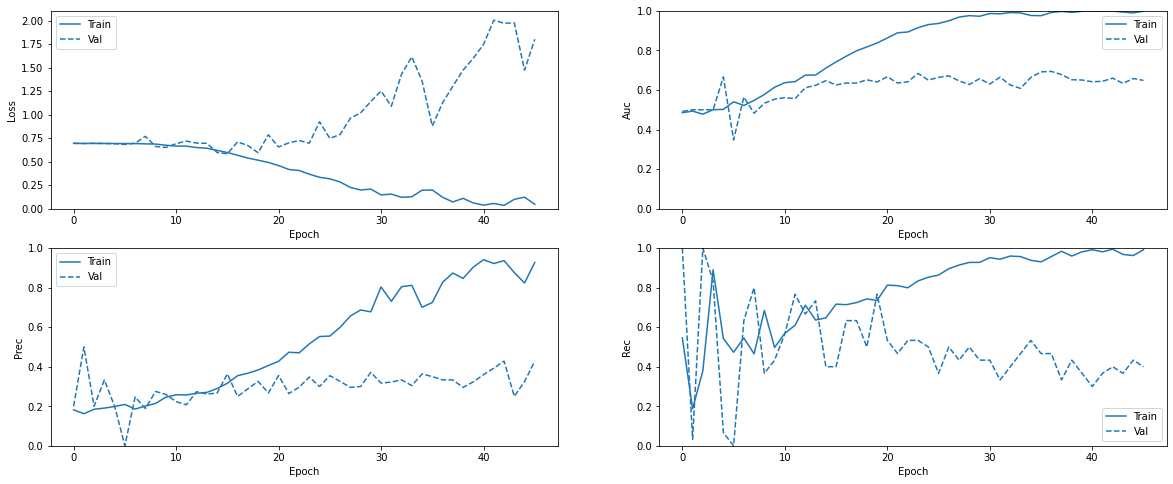

[mc1] Training with activation=elu
Epoch 1/60
63/63 [==============================] - 16s 228ms/step - loss: 0.7069 - tp: 89.4844 - fp: 354.4375 - tn: 489.3594 - fn: 105.7188 - acc: 0.5650 - prec: 0.1967 - rec: 0.4386 - auc: 0.5021 - val_loss: 0.6220 - val_tp: 7.0000 - val_fp: 11.0000 - val_tn: 109.0000 - val_fn: 23.0000 - val_acc: 0.7733 - val_prec: 0.3889 - val_rec: 0.2333 - val_auc: 0.5894

Epoch 00001: saving model to mc1_act_elu_model.h5
Epoch 2/60
63/63 [==============================] - 13s 206ms/step - loss: 0.6699 - tp: 91.0156 - fp: 288.6094 - tn: 559.9062 - fn: 99.4688 - acc: 0.6405 - prec: 0.2291 - rec: 0.4462 - auc: 0.5833 - val_loss: 0.6682 - val_tp: 10.0000 - val_fp: 38.0000 - val_tn: 82.0000 - val_fn: 20.0000 - val_acc: 0.6133 - val_prec: 0.2083 - val_rec: 0.3333 - val_auc: 0.5826

Epoch 00002: saving model to mc1_act_elu_model.h5
Epoch 3/60
63/63 [==============================] - 13s 206ms/step - loss: 0.6747 - tp: 120.9844 - fp: 367.8281 - tn: 477.2344 - fn: 72.9531

'Best model in val (lower val_loss)'

'epoch: 2'

'val_loss: 0.5669310688972473'

'val_auc: 0.5880554914474487'

'val_prec: 0.1428571492433548'

'val_rec: 0.03333333507180214'

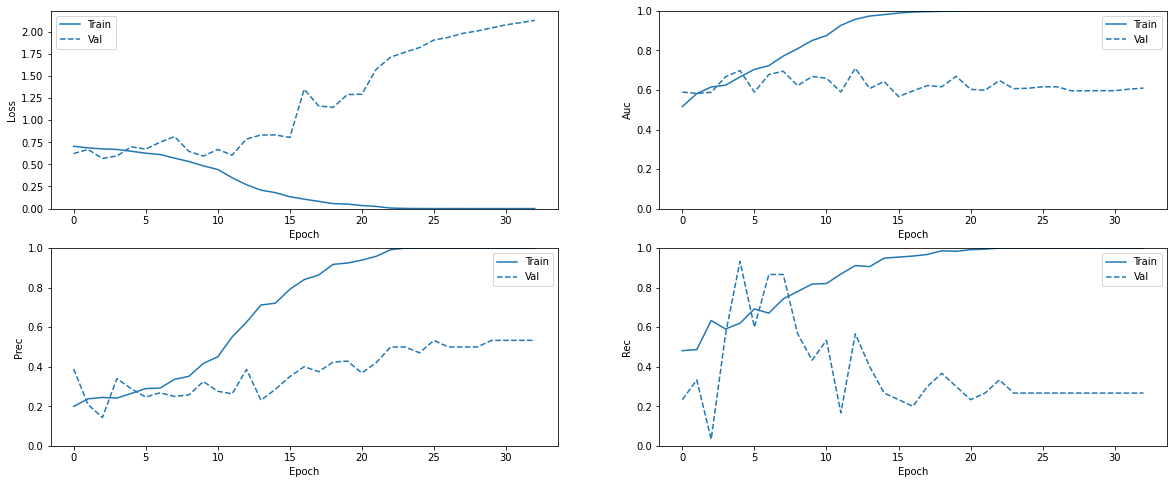

[mc1] Training with activation=tanh
Epoch 1/60
63/63 [==============================] - 14s 204ms/step - loss: 0.7072 - tp: 79.2969 - fp: 290.7031 - tn: 553.0938 - fn: 115.9062 - acc: 0.6052 - prec: 0.2068 - rec: 0.3969 - auc: 0.5091 - val_loss: 0.6346 - val_tp: 8.0000 - val_fp: 18.0000 - val_tn: 102.0000 - val_fn: 22.0000 - val_acc: 0.7333 - val_prec: 0.3077 - val_rec: 0.2667 - val_auc: 0.5962

Epoch 00001: saving model to mc1_act_tanh_model.h5
Epoch 2/60
63/63 [==============================] - 12s 194ms/step - loss: 0.6733 - tp: 95.3594 - fp: 349.2031 - tn: 499.3125 - fn: 95.1250 - acc: 0.5975 - prec: 0.2096 - rec: 0.4616 - auc: 0.5711 - val_loss: 0.6665 - val_tp: 23.0000 - val_fp: 51.0000 - val_tn: 69.0000 - val_fn: 7.0000 - val_acc: 0.6133 - val_prec: 0.3108 - val_rec: 0.7667 - val_auc: 0.7249

Epoch 00002: saving model to mc1_act_tanh_model.h5
Epoch 3/60
63/63 [==============================] - 12s 193ms/step - loss: 0.6693 - tp: 124.1406 - fp: 373.4531 - tn: 471.6094 - fn: 69.79

'Best model in val (lower val_loss)'

'epoch: 12'

'val_loss: 0.4836750328540802'

'val_auc: 0.7704167366027832'

'val_prec: 0.39024388790130615'

'val_rec: 0.5333333611488342'

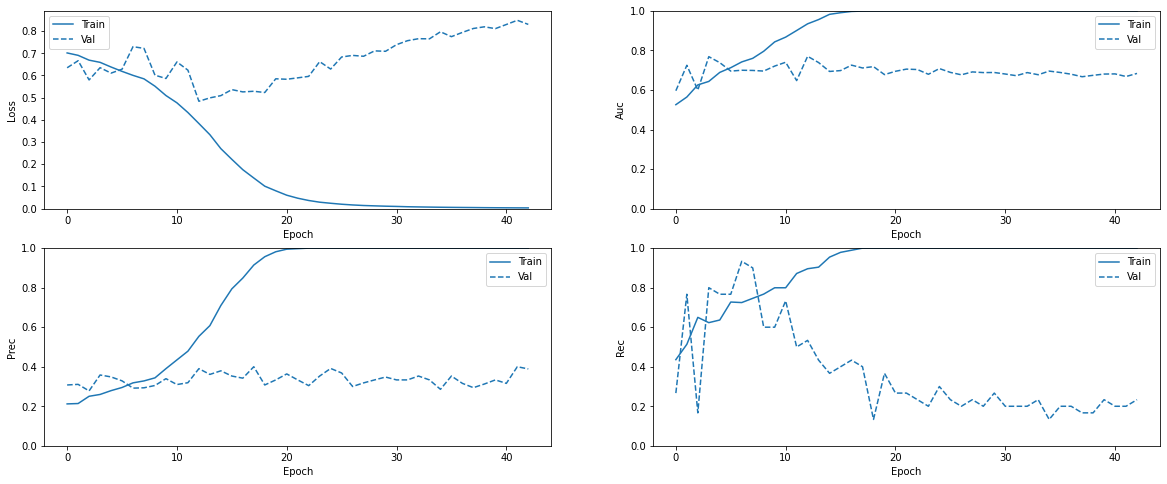


Evaluate optimizers
[mc1] Training with optimizer=adam
Epoch 1/60
63/63 [==============================] - 12s 169ms/step - loss: 0.6905 - tp: 67.2656 - fp: 297.8906 - tn: 545.9062 - fn: 127.9375 - acc: 0.6365 - prec: 0.1728 - rec: 0.2713 - auc: 0.4842 - val_loss: 0.6956 - val_tp: 30.0000 - val_fp: 120.0000 - val_tn: 0.0000e+00 - val_fn: 0.0000e+00 - val_acc: 0.2000 - val_prec: 0.2000 - val_rec: 1.0000 - val_auc: 0.5000

Epoch 00001: saving model to mc1_opt_adam_model.h5
Epoch 2/60
63/63 [==============================] - 10s 157ms/step - loss: 0.6799 - tp: 136.5312 - fp: 616.2188 - tn: 232.2969 - fn: 53.9531 - acc: 0.2862 - prec: 0.1763 - rec: 0.8215 - auc: 0.5001 - val_loss: 0.6927 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 120.0000 - val_fn: 30.0000 - val_acc: 0.8000 - val_prec: 0.0000e+00 - val_rec: 0.0000e+00 - val_auc: 0.5000

Epoch 00002: saving model to mc1_opt_adam_model.h5
Epoch 3/60
63/63 [==============================] - 10s 157ms/step - loss: 0.6938 - tp: 83.703

'Best model in val (lower val_loss)'

'epoch: 2'

'val_loss: 0.562095046043396'

'val_auc: 0.6737500429153442'

'val_prec: 0.34375'

'val_rec: 0.36666667461395264'

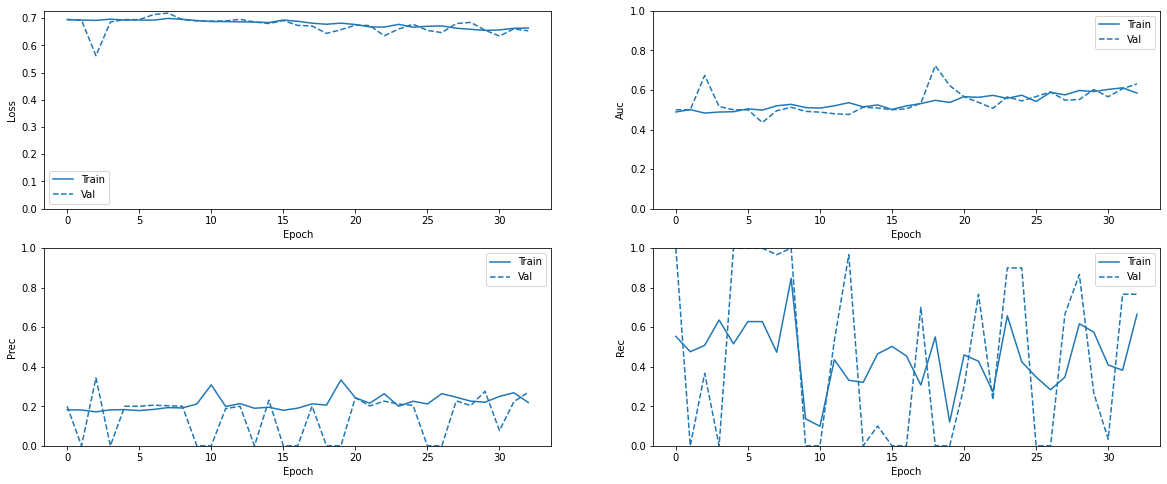

[mc1] Training with optimizer=adagrad
Epoch 1/60
63/63 [==============================] - 12s 171ms/step - loss: 0.6891 - tp: 195.2031 - fp: 842.3750 - tn: 1.4219 - fn: 0.0000e+00 - acc: 0.1852 - prec: 0.1842 - rec: 1.0000 - auc: 0.4974 - val_loss: 0.6968 - val_tp: 30.0000 - val_fp: 120.0000 - val_tn: 0.0000e+00 - val_fn: 0.0000e+00 - val_acc: 0.2000 - val_prec: 0.2000 - val_rec: 1.0000 - val_auc: 0.4208

Epoch 00001: saving model to mc1_opt_adagrad_model.h5
Epoch 2/60
63/63 [==============================] - 10s 159ms/step - loss: 0.6799 - tp: 190.4844 - fp: 848.5156 - tn: 0.0000e+00 - fn: 0.0000e+00 - acc: 0.1776 - prec: 0.1776 - rec: 1.0000 - auc: 0.4859 - val_loss: 0.6971 - val_tp: 30.0000 - val_fp: 120.0000 - val_tn: 0.0000e+00 - val_fn: 0.0000e+00 - val_acc: 0.2000 - val_prec: 0.2000 - val_rec: 1.0000 - val_auc: 0.4500

Epoch 00002: saving model to mc1_opt_adagrad_model.h5
Epoch 3/60
63/63 [==============================] - 10s 159ms/step - loss: 0.6939 - tp: 193.9375 - fp: 844.3

'Best model in val (lower val_loss)'

'epoch: 58'

'val_loss: 0.6829685568809509'

'val_auc: 0.7483333349227905'

'val_prec: 0.3709677457809448'

'val_rec: 0.7666666507720947'

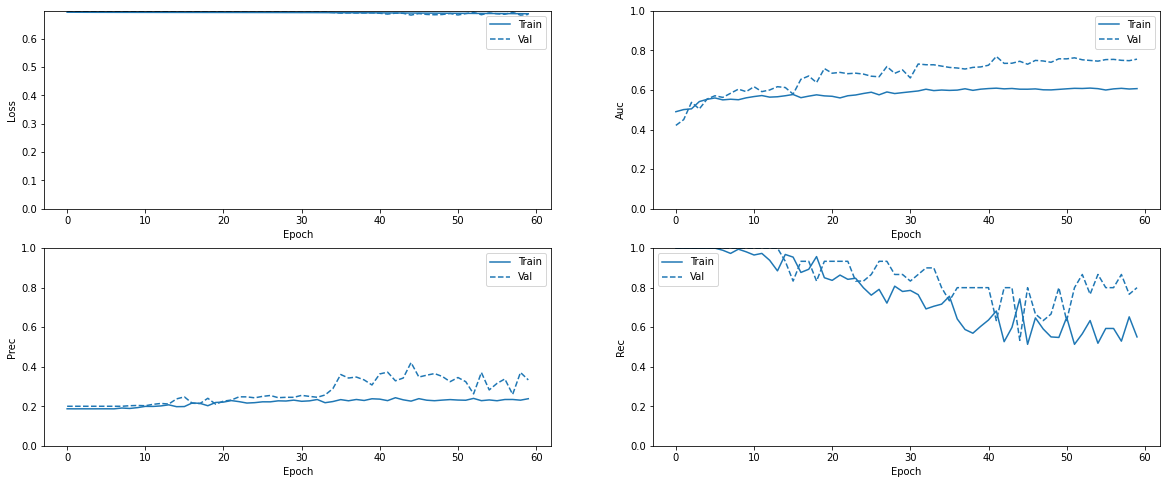

[mc1] Training with optimizer=RMSprop
Epoch 1/60
63/63 [==============================] - 13s 169ms/step - loss: 0.6912 - tp: 84.6406 - fp: 374.1875 - tn: 469.6094 - fn: 110.5625 - acc: 0.5616 - prec: 0.1749 - rec: 0.3809 - auc: 0.4856 - val_loss: 0.6728 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 120.0000 - val_fn: 30.0000 - val_acc: 0.8000 - val_prec: 0.0000e+00 - val_rec: 0.0000e+00 - val_auc: 0.6803

Epoch 00001: saving model to mc1_opt_RMSprop_model.h5
Epoch 2/60
63/63 [==============================] - 10s 157ms/step - loss: 0.6810 - tp: 26.7656 - fp: 126.2812 - tn: 722.2344 - fn: 163.7188 - acc: 0.7470 - prec: 0.1395 - rec: 0.1052 - auc: 0.4909 - val_loss: 0.7047 - val_tp: 30.0000 - val_fp: 120.0000 - val_tn: 0.0000e+00 - val_fn: 0.0000e+00 - val_acc: 0.2000 - val_prec: 0.2000 - val_rec: 1.0000 - val_auc: 0.5000

Epoch 00002: saving model to mc1_opt_RMSprop_model.h5
Epoch 3/60
63/63 [==============================] - 10s 157ms/step - loss: 0.6967 - tp: 122.6406 - fp: 550

'Best model in val (lower val_loss)'

'epoch: 12'

'val_loss: 0.471619576215744'

'val_auc: 0.7441666722297668'

'val_prec: 0.4642857015132904'

'val_rec: 0.4333333373069763'

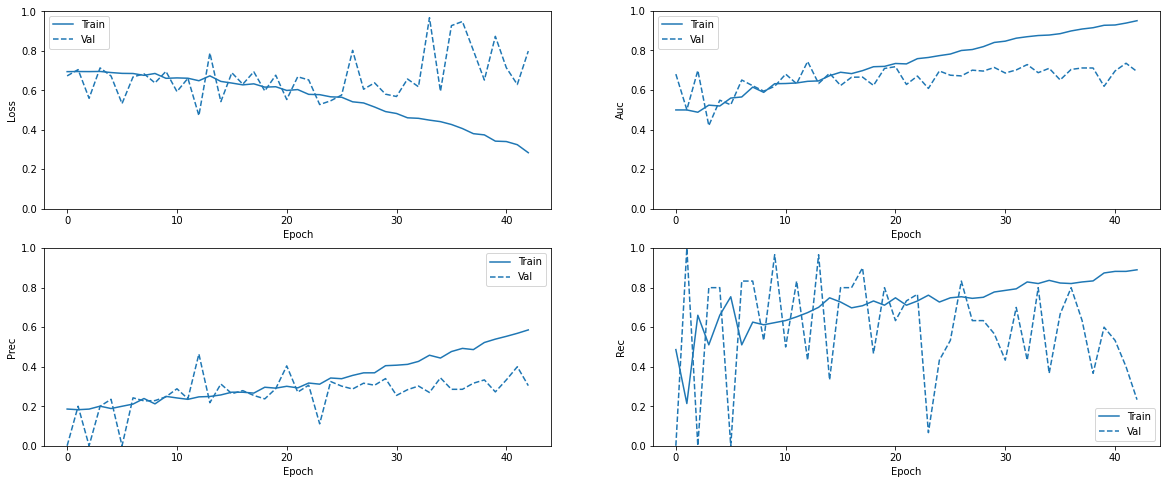


Evaluate kernel regularizers
[mc1] Training with regularization=None
Epoch 1/60
63/63 [==============================] - 12s 169ms/step - loss: 0.6903 - tp: 67.4219 - fp: 295.9219 - tn: 547.8750 - fn: 127.7812 - acc: 0.6377 - prec: 0.1744 - rec: 0.2724 - auc: 0.4795 - val_loss: 0.6925 - val_tp: 4.0000 - val_fp: 1.0000 - val_tn: 119.0000 - val_fn: 26.0000 - val_acc: 0.8200 - val_prec: 0.8000 - val_rec: 0.1333 - val_auc: 0.5000

Epoch 00001: saving model to mc1_reg_None_model.h5
Epoch 2/60
63/63 [==============================] - 10s 156ms/step - loss: 0.6798 - tp: 66.4219 - fp: 283.4219 - tn: 565.0938 - fn: 124.0625 - acc: 0.6399 - prec: 0.1570 - rec: 0.3020 - auc: 0.4833 - val_loss: 0.6948 - val_tp: 29.0000 - val_fp: 119.0000 - val_tn: 1.0000 - val_fn: 1.0000 - val_acc: 0.2000 - val_prec: 0.1959 - val_rec: 0.9667 - val_auc: 0.5000

Epoch 00002: saving model to mc1_reg_None_model.h5
Epoch 3/60
63/63 [==============================] - 10s 156ms/step - loss: 0.6945 - tp: 69.2656 - fp: 30

'Best model in val (lower val_loss)'

'epoch: 23'

'val_loss: 0.5455278754234314'

'val_auc: 0.6774999499320984'

'val_prec: 0.4137931168079376'

'val_rec: 0.4000000059604645'

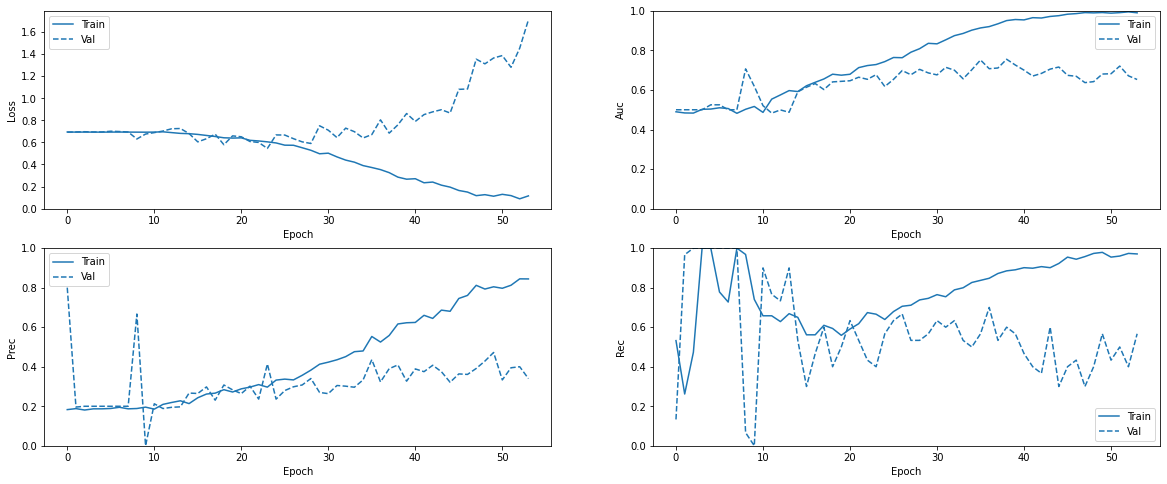

[mc1] Training with regularization=l2_0.001
Epoch 1/60
63/63 [==============================] - 13s 169ms/step - loss: 0.8168 - tp: 51.3438 - fp: 230.1562 - tn: 613.6406 - fn: 143.8594 - acc: 0.6723 - prec: 0.1721 - rec: 0.2139 - auc: 0.4767 - val_loss: 0.7298 - val_tp: 30.0000 - val_fp: 120.0000 - val_tn: 0.0000e+00 - val_fn: 0.0000e+00 - val_acc: 0.2000 - val_prec: 0.2000 - val_rec: 1.0000 - val_auc: 0.5000

Epoch 00001: saving model to mc1_reg_l2_0.001_model.h5
Epoch 2/60
63/63 [==============================] - 10s 158ms/step - loss: 0.7062 - tp: 54.7812 - fp: 288.8906 - tn: 559.6250 - fn: 135.7031 - acc: 0.5185 - prec: 0.1550 - rec: 0.3870 - auc: 0.5000 - val_loss: 0.7044 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 120.0000 - val_fn: 30.0000 - val_acc: 0.8000 - val_prec: 0.0000e+00 - val_rec: 0.0000e+00 - val_auc: 0.5000

Epoch 00002: saving model to mc1_reg_l2_0.001_model.h5
Epoch 3/60
63/63 [==============================] - 10s 159ms/step - loss: 0.7041 - tp: 63.3438 - 

'Best model in val (lower val_loss)'

'epoch: 10'

'val_loss: 0.6922144293785095'

'val_auc: 0.5'

'val_prec: 0.0'

'val_rec: 0.0'

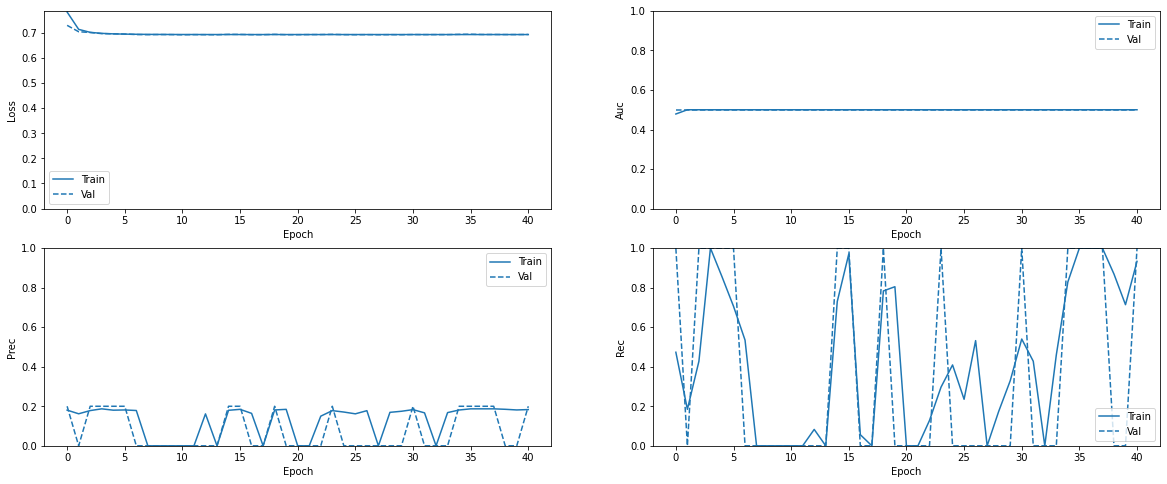

[mc1] Training with regularization=l2_0.01
Epoch 1/60
63/63 [==============================] - 12s 171ms/step - loss: 1.8392 - tp: 49.0000 - fp: 239.3438 - tn: 604.4531 - fn: 146.2031 - acc: 0.6388 - prec: 0.1576 - rec: 0.2341 - auc: 0.5016 - val_loss: 0.8400 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 120.0000 - val_fn: 30.0000 - val_acc: 0.8000 - val_prec: 0.0000e+00 - val_rec: 0.0000e+00 - val_auc: 0.5000

Epoch 00001: saving model to mc1_reg_l2_0.01_model.h5
Epoch 2/60
63/63 [==============================] - 10s 160ms/step - loss: 0.7657 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 848.5156 - fn: 190.4844 - acc: 0.8224 - prec: 0.0000e+00 - rec: 0.0000e+00 - auc: 0.5000 - val_loss: 0.6996 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 120.0000 - val_fn: 30.0000 - val_acc: 0.8000 - val_prec: 0.0000e+00 - val_rec: 0.0000e+00 - val_auc: 0.5000

Epoch 00002: saving model to mc1_reg_l2_0.01_model.h5
Epoch 3/60
63/63 [==============================] - 10s 158ms/step - loss: 0.698

'Best model in val (lower val_loss)'

'epoch: 10'

'val_loss: 0.6920956969261169'

'val_auc: 0.5'

'val_prec: 0.0'

'val_rec: 0.0'

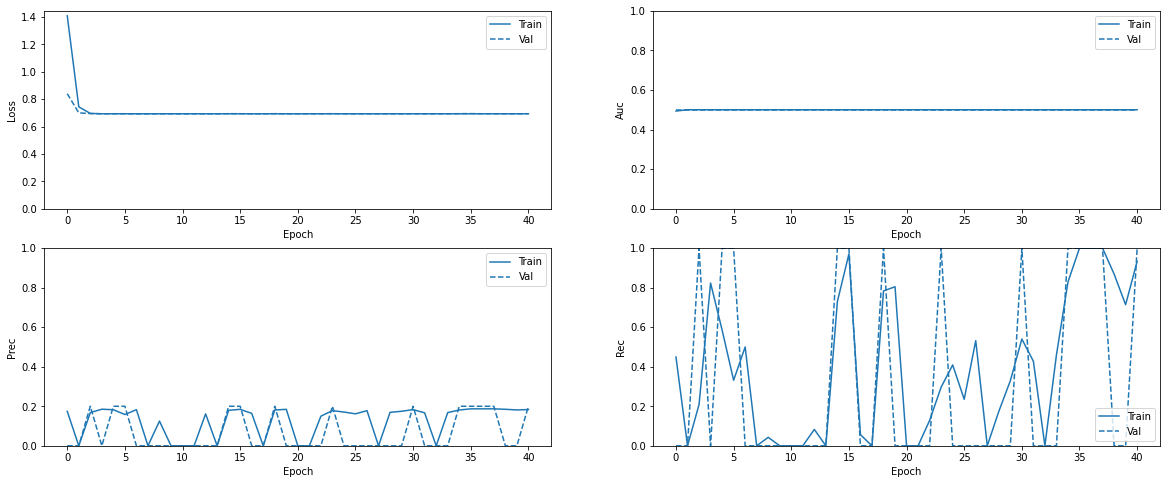

[mc1] Training with regularization=l2_1.0
Epoch 1/60
63/63 [==============================] - 13s 172ms/step - loss: 114.6276 - tp: 8.9375 - fp: 54.5469 - tn: 789.2500 - fn: 186.2656 - acc: 0.7214 - prec: 0.1409 - rec: 0.1100 - auc: 0.4730 - val_loss: 14.3616 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 120.0000 - val_fn: 30.0000 - val_acc: 0.8000 - val_prec: 0.0000e+00 - val_rec: 0.0000e+00 - val_auc: 0.5000

Epoch 00001: saving model to mc1_reg_l2_1.0_model.h5
Epoch 2/60
63/63 [==============================] - 10s 159ms/step - loss: 8.5680 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 848.5156 - fn: 190.4844 - acc: 0.8224 - prec: 0.0000e+00 - rec: 0.0000e+00 - auc: 0.4971 - val_loss: 1.3260 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 120.0000 - val_fn: 30.0000 - val_acc: 0.8000 - val_prec: 0.0000e+00 - val_rec: 0.0000e+00 - val_auc: 0.5000

Epoch 00002: saving model to mc1_reg_l2_1.0_model.h5
Epoch 3/60
63/63 [==============================] - 10s 158ms/step - loss: 1.0288 

'Best model in val (lower val_loss)'

'epoch: 6'

'val_loss: 0.6917860507965088'

'val_auc: 0.5'

'val_prec: 0.0'

'val_rec: 0.0'

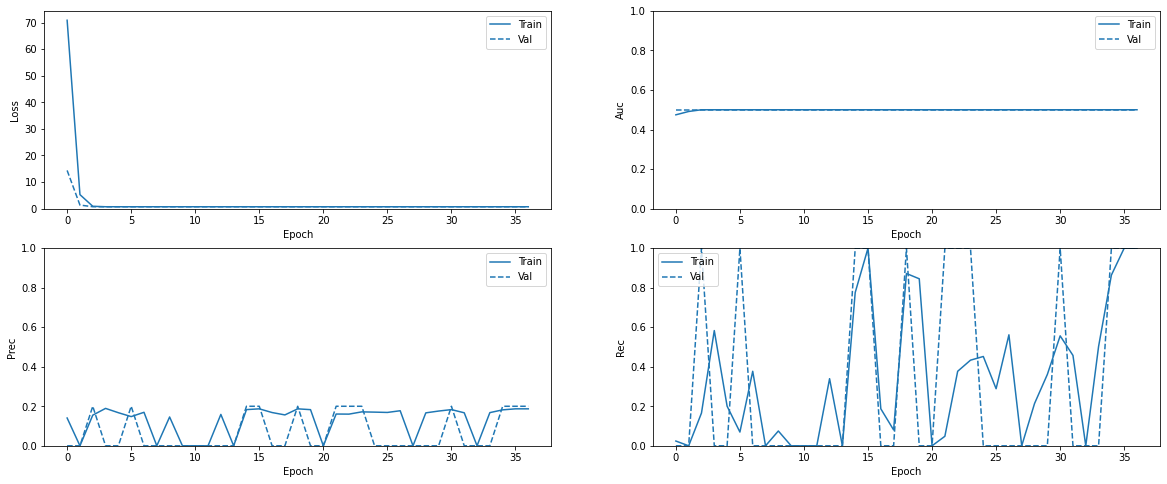

[mc1] Training with regularization=l2_1.5
Epoch 1/60
63/63 [==============================] - 12s 171ms/step - loss: 171.5963 - tp: 12.5000 - fp: 76.9531 - tn: 766.8438 - fn: 182.7031 - acc: 0.7104 - prec: 0.1391 - rec: 0.1200 - auc: 0.4796 - val_loss: 21.1963 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 120.0000 - val_fn: 30.0000 - val_acc: 0.8000 - val_prec: 0.0000e+00 - val_rec: 0.0000e+00 - val_auc: 0.5000

Epoch 00001: saving model to mc1_reg_l2_1.5_model.h5
Epoch 2/60
63/63 [==============================] - 10s 158ms/step - loss: 12.5120 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 848.5156 - fn: 190.4844 - acc: 0.8224 - prec: 0.0000e+00 - rec: 0.0000e+00 - auc: 0.4760 - val_loss: 1.6437 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 120.0000 - val_fn: 30.0000 - val_acc: 0.8000 - val_prec: 0.0000e+00 - val_rec: 0.0000e+00 - val_auc: 0.5000

Epoch 00002: saving model to mc1_reg_l2_1.5_model.h5
Epoch 3/60
63/63 [==============================] - 10s 158ms/step - loss: 1.196

'Best model in val (lower val_loss)'

'epoch: 6'

'val_loss: 0.6910495162010193'

'val_auc: 0.5'

'val_prec: 0.0'

'val_rec: 0.0'

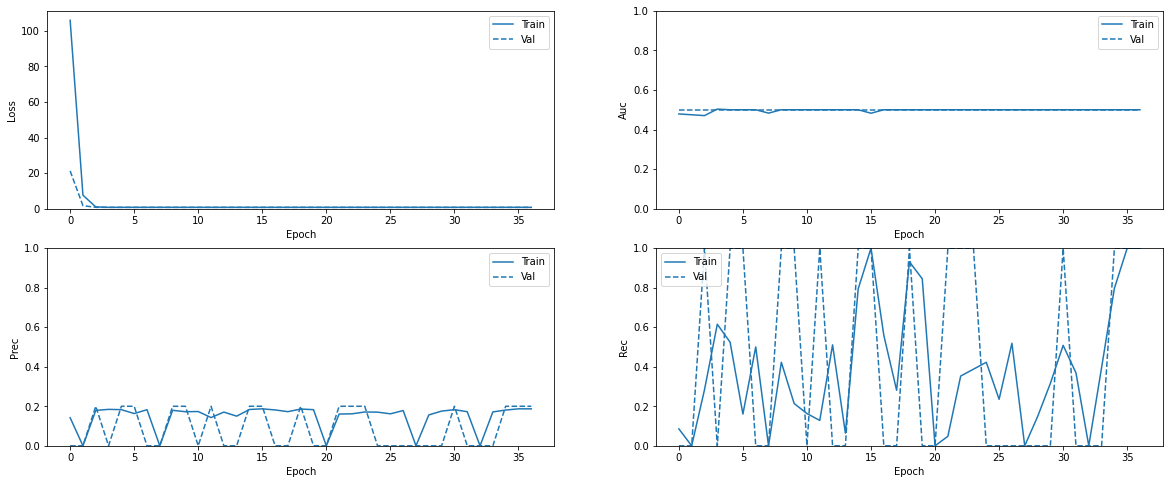

In [12]:
# Model candidate 1

# Variation of baseline model with two more CNN layers
# (tried to have similar params number by increasing number of filters in the first CNN layers).

def model_mc1(cnn_activation="relu", kernel_regularizer=None):
  return tf.keras.Sequential([
      layers.experimental.preprocessing.Rescaling(scale=1./255),
      layers.Conv2D(128, 3, activation=cnn_activation,
                    kernel_regularizer=kernel_regularizer),
      layers.MaxPooling2D(),
      layers.Conv2D(32, 3, activation=cnn_activation,
                    kernel_regularizer=kernel_regularizer),
      layers.MaxPooling2D(),
      layers.Conv2D(32, 3, activation=cnn_activation,
                    kernel_regularizer=kernel_regularizer),
      layers.MaxPooling2D(),
      layers.Conv2D(32, 3, activation=cnn_activation,
                    kernel_regularizer=kernel_regularizer),
      layers.MaxPooling2D(),
      layers.Conv2D(32, 3, activation=cnn_activation,
                    kernel_regularizer=kernel_regularizer),
      layers.MaxPooling2D(),
      layers.Conv2D(32, 3, activation=cnn_activation,
                    kernel_regularizer=kernel_regularizer),
      layers.MaxPooling2D(),
      layers.Flatten(),
      layers.Dense(1, activation='sigmoid')
    ])

md = model_mc1()
md.build((None, 299, 299, 3))
display(md.summary())
mc1_hist_acts, mc1_hist_opts, mc1_hist_regs = do_experiment(model_mc1, tag="mc1") 

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_13 (Rescaling)     (None, 299, 299, 3)       0         
_________________________________________________________________
conv2d_76 (Conv2D)           (None, 293, 293, 64)      9472      
_________________________________________________________________
max_pooling2d_76 (MaxPooling (None, 97, 97, 64)        0         
_________________________________________________________________
conv2d_77 (Conv2D)           (None, 95, 95, 32)        18464     
_________________________________________________________________
max_pooling2d_77 (MaxPooling (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_78 (Conv2D)           (None, 29, 29, 64)        18496     
_________________________________________________________________
max_pooling2d_78 (MaxPooling (None, 9, 9, 64)        

None


Evaluate activation functions
[mc2] Training with activation=relu
Epoch 1/60
63/63 [==============================] - 9s 108ms/step - loss: 0.6932 - tp: 105.0156 - fp: 452.8125 - tn: 390.9844 - fn: 90.1875 - acc: 0.5016 - prec: 0.1802 - rec: 0.4864 - auc: 0.4878 - val_loss: 0.6576 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 120.0000 - val_fn: 30.0000 - val_acc: 0.8000 - val_prec: 0.0000e+00 - val_rec: 0.0000e+00 - val_auc: 0.6911

Epoch 00001: saving model to mc2_act_relu_model.h5
Epoch 2/60
63/63 [==============================] - 6s 91ms/step - loss: 0.6836 - tp: 92.4219 - fp: 424.4219 - tn: 424.0938 - fn: 98.0625 - acc: 0.5529 - prec: 0.1504 - rec: 0.4075 - auc: 0.4931 - val_loss: 0.6961 - val_tp: 30.0000 - val_fp: 120.0000 - val_tn: 0.0000e+00 - val_fn: 0.0000e+00 - val_acc: 0.2000 - val_prec: 0.2000 - val_rec: 1.0000 - val_auc: 0.5083

Epoch 00002: saving model to mc2_act_relu_model.h5
Epoch 3/60
63/63 [==============================] - 6s 91ms/step - loss: 0.6940 - tp: 1

'Best model in val (lower val_loss)'

'epoch: 28'

'val_loss: 0.6172990202903748'

'val_auc: 0.5663889050483704'

'val_prec: 0.4615384638309479'

'val_rec: 0.20000000298023224'

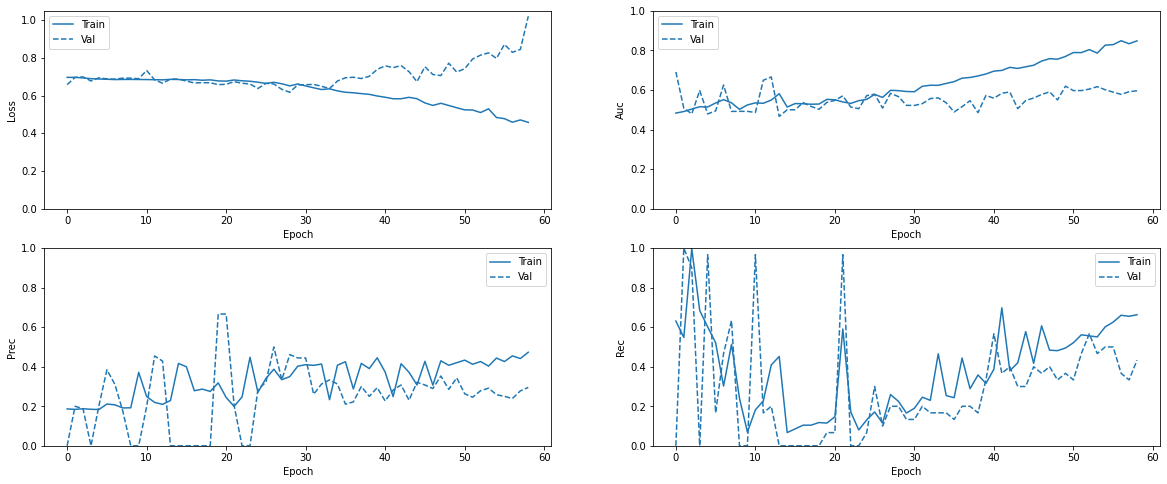

[mc2] Training with activation=elu
Epoch 1/60
63/63 [==============================] - 10s 132ms/step - loss: 0.7144 - tp: 91.6250 - fp: 376.8125 - tn: 466.9844 - fn: 103.5781 - acc: 0.5678 - prec: 0.1807 - rec: 0.4120 - auc: 0.5201 - val_loss: 0.7418 - val_tp: 29.0000 - val_fp: 114.0000 - val_tn: 6.0000 - val_fn: 1.0000 - val_acc: 0.2333 - val_prec: 0.2028 - val_rec: 0.9667 - val_auc: 0.7113

Epoch 00001: saving model to mc2_act_elu_model.h5
Epoch 2/60
63/63 [==============================] - 7s 116ms/step - loss: 0.6874 - tp: 86.7969 - fp: 351.5312 - tn: 496.9844 - fn: 103.6875 - acc: 0.5546 - prec: 0.1915 - rec: 0.4623 - auc: 0.5344 - val_loss: 0.6962 - val_tp: 23.0000 - val_fp: 65.0000 - val_tn: 55.0000 - val_fn: 7.0000 - val_acc: 0.5200 - val_prec: 0.2614 - val_rec: 0.7667 - val_auc: 0.6843

Epoch 00002: saving model to mc2_act_elu_model.h5
Epoch 3/60
63/63 [==============================] - 7s 117ms/step - loss: 0.6851 - tp: 115.5625 - fp: 387.0156 - tn: 458.0469 - fn: 78.3750 - 

'Best model in val (lower val_loss)'

'epoch: 9'

'val_loss: 0.5264058709144592'

'val_auc: 0.7418056130409241'

'val_prec: 0.38235294818878174'

'val_rec: 0.4333333373069763'

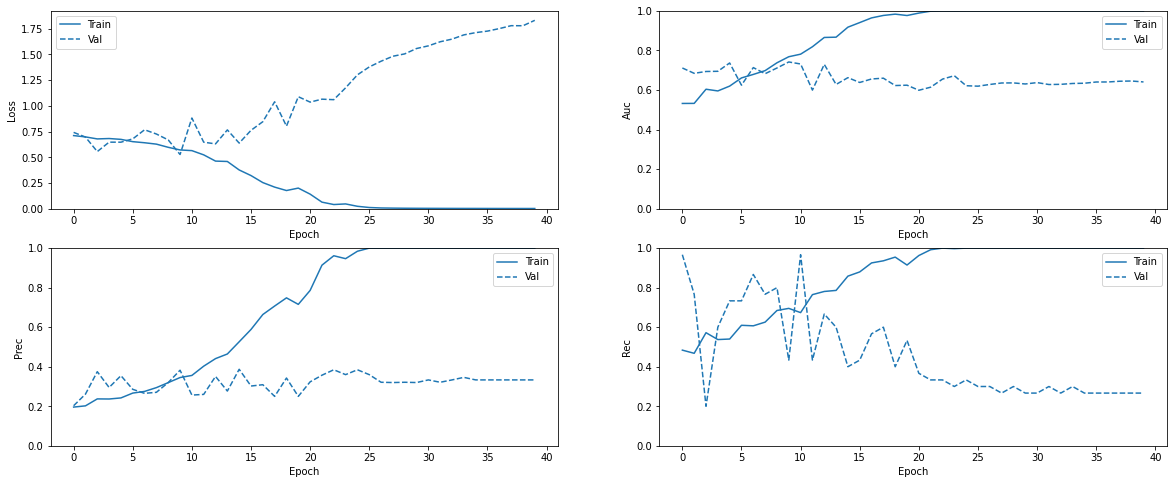

[mc2] Training with activation=tanh
Epoch 1/60
63/63 [==============================] - 9s 129ms/step - loss: 0.7190 - tp: 89.5781 - fp: 359.9062 - tn: 483.8906 - fn: 105.6250 - acc: 0.5779 - prec: 0.1843 - rec: 0.4073 - auc: 0.5153 - val_loss: 0.7729 - val_tp: 30.0000 - val_fp: 119.0000 - val_tn: 1.0000 - val_fn: 0.0000e+00 - val_acc: 0.2067 - val_prec: 0.2013 - val_rec: 1.0000 - val_auc: 0.7121

Epoch 00001: saving model to mc2_act_tanh_model.h5
Epoch 2/60
63/63 [==============================] - 7s 112ms/step - loss: 0.6877 - tp: 78.8125 - fp: 340.5156 - tn: 508.0000 - fn: 111.6719 - acc: 0.5682 - prec: 0.1847 - rec: 0.4135 - auc: 0.5395 - val_loss: 0.7062 - val_tp: 25.0000 - val_fp: 79.0000 - val_tn: 41.0000 - val_fn: 5.0000 - val_acc: 0.4400 - val_prec: 0.2404 - val_rec: 0.8333 - val_auc: 0.6504

Epoch 00002: saving model to mc2_act_tanh_model.h5
Epoch 3/60
63/63 [==============================] - 7s 112ms/step - loss: 0.6886 - tp: 118.6719 - fp: 388.0938 - tn: 456.9688 - fn: 75.2

'Best model in val (lower val_loss)'

'epoch: 5'

'val_loss: 0.4979696571826935'

'val_auc: 0.6286110877990723'

'val_prec: 0.0'

'val_rec: 0.0'

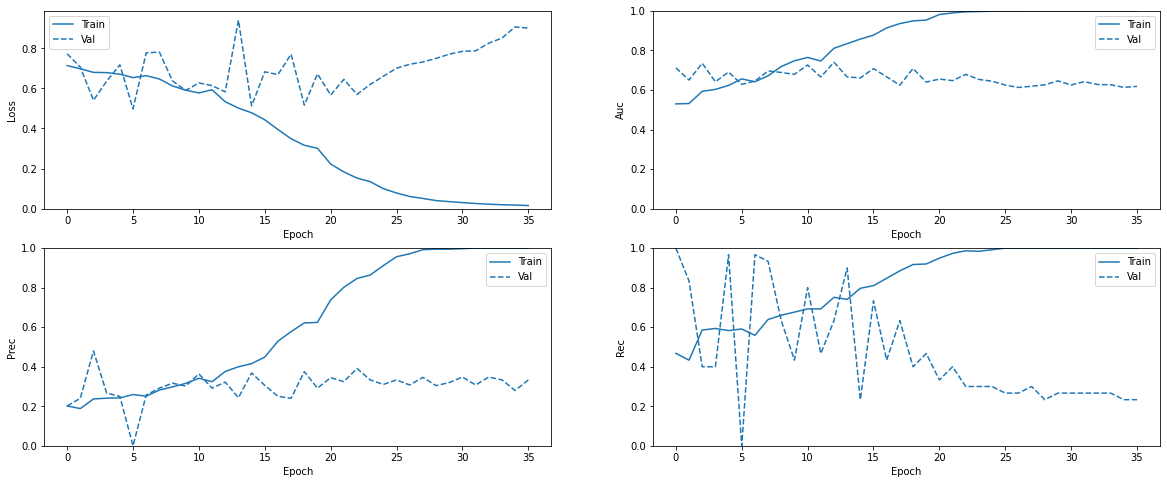


Evaluate optimizers
[mc2] Training with optimizer=adam
Epoch 1/60
63/63 [==============================] - 8s 108ms/step - loss: 0.6930 - tp: 108.4375 - fp: 479.1719 - tn: 364.6250 - fn: 86.7656 - acc: 0.4776 - prec: 0.1754 - rec: 0.5042 - auc: 0.4875 - val_loss: 0.6752 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 120.0000 - val_fn: 30.0000 - val_acc: 0.8000 - val_prec: 0.0000e+00 - val_rec: 0.0000e+00 - val_auc: 0.6536

Epoch 00001: saving model to mc2_opt_adam_model.h5
Epoch 2/60
63/63 [==============================] - 6s 91ms/step - loss: 0.6827 - tp: 117.4062 - fp: 527.8594 - tn: 320.6562 - fn: 73.0781 - acc: 0.5273 - prec: 0.1474 - rec: 0.4572 - auc: 0.4793 - val_loss: 0.6956 - val_tp: 30.0000 - val_fp: 120.0000 - val_tn: 0.0000e+00 - val_fn: 0.0000e+00 - val_acc: 0.2000 - val_prec: 0.2000 - val_rec: 1.0000 - val_auc: 0.5958

Epoch 00002: saving model to mc2_opt_adam_model.h5
Epoch 3/60
63/63 [==============================] - 6s 91ms/step - loss: 0.6935 - tp: 163.3906 - 

'Best model in val (lower val_loss)'

'epoch: 12'

'val_loss: 0.4972410202026367'

'val_auc: 0.73375004529953'

'val_prec: 0.3870967626571655'

'val_rec: 0.4000000059604645'

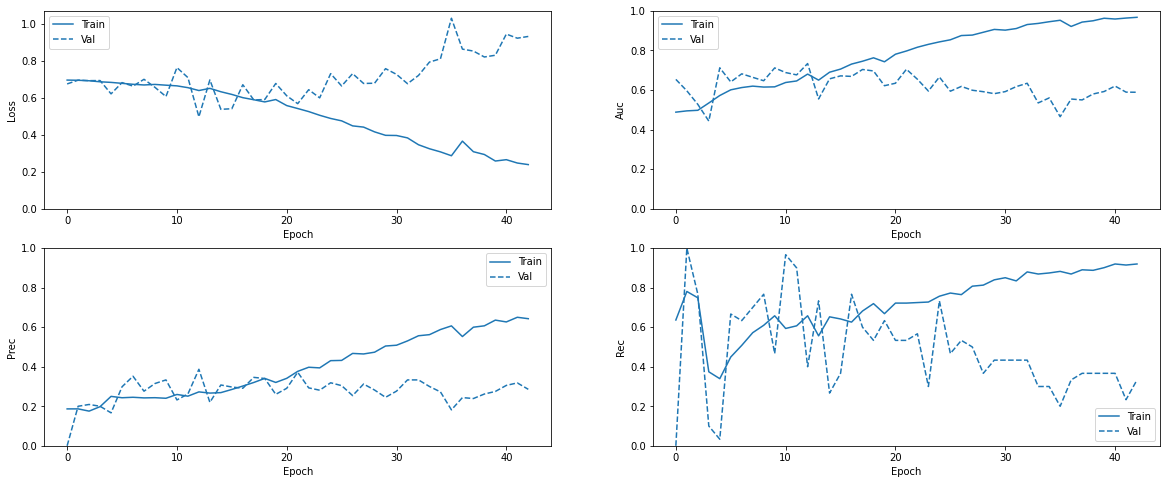

[mc2] Training with optimizer=adagrad
Epoch 1/60
63/63 [==============================] - 8s 107ms/step - loss: 0.6900 - tp: 153.0469 - fp: 670.6250 - tn: 173.1719 - fn: 42.1562 - acc: 0.2902 - prec: 0.1817 - rec: 0.8150 - auc: 0.4710 - val_loss: 0.6849 - val_tp: 2.0000 - val_fp: 4.0000 - val_tn: 116.0000 - val_fn: 28.0000 - val_acc: 0.7867 - val_prec: 0.3333 - val_rec: 0.0667 - val_auc: 0.6606

Epoch 00001: saving model to mc2_opt_adagrad_model.h5
Epoch 2/60
63/63 [==============================] - 6s 95ms/step - loss: 0.6789 - tp: 12.3750 - fp: 36.8594 - tn: 811.6562 - fn: 178.1094 - acc: 0.8007 - prec: 0.2028 - rec: 0.0552 - auc: 0.5197 - val_loss: 0.6900 - val_tp: 21.0000 - val_fp: 40.0000 - val_tn: 80.0000 - val_fn: 9.0000 - val_acc: 0.6733 - val_prec: 0.3443 - val_rec: 0.7000 - val_auc: 0.7207

Epoch 00002: saving model to mc2_opt_adagrad_model.h5
Epoch 3/60
63/63 [==============================] - 6s 95ms/step - loss: 0.6928 - tp: 55.5938 - fp: 202.3906 - tn: 642.6719 - fn: 138.

'Best model in val (lower val_loss)'

'epoch: 44'

'val_loss: 0.5714048743247986'

'val_auc: 0.7545833587646484'

'val_prec: 0.5714285969734192'

'val_rec: 0.4000000059604645'

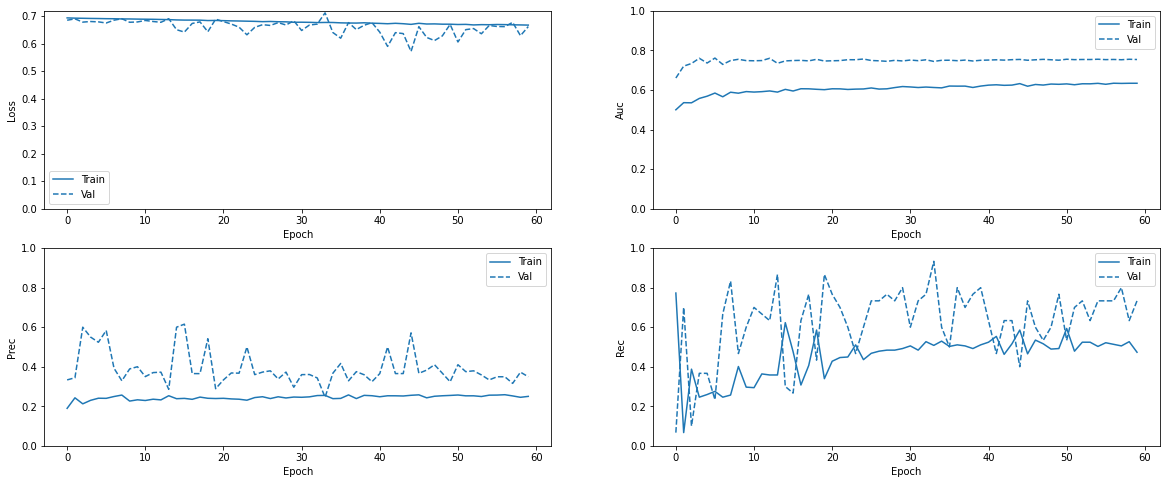

[mc2] Training with optimizer=RMSprop
Epoch 1/60
63/63 [==============================] - 8s 104ms/step - loss: 0.7101 - tp: 96.4375 - fp: 427.6562 - tn: 416.1406 - fn: 98.7656 - acc: 0.4887 - prec: 0.1725 - rec: 0.4735 - auc: 0.4804 - val_loss: 0.6475 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 120.0000 - val_fn: 30.0000 - val_acc: 0.8000 - val_prec: 0.0000e+00 - val_rec: 0.0000e+00 - val_auc: 0.7054

Epoch 00001: saving model to mc2_opt_RMSprop_model.h5
Epoch 2/60
63/63 [==============================] - 6s 92ms/step - loss: 0.6822 - tp: 45.9844 - fp: 195.6562 - tn: 652.8594 - fn: 144.5000 - acc: 0.6995 - prec: 0.1697 - rec: 0.2107 - auc: 0.4947 - val_loss: 0.7133 - val_tp: 30.0000 - val_fp: 120.0000 - val_tn: 0.0000e+00 - val_fn: 0.0000e+00 - val_acc: 0.2000 - val_prec: 0.2000 - val_rec: 1.0000 - val_auc: 0.4281

Epoch 00002: saving model to mc2_opt_RMSprop_model.h5
Epoch 3/60
63/63 [==============================] - 6s 92ms/step - loss: 0.7055 - tp: 124.7969 - fp: 549.7031 

'Best model in val (lower val_loss)'

'epoch: 12'

'val_loss: 0.45080679655075073'

'val_auc: 0.7040277719497681'

'val_prec: 1.0'

'val_rec: 0.06666667014360428'

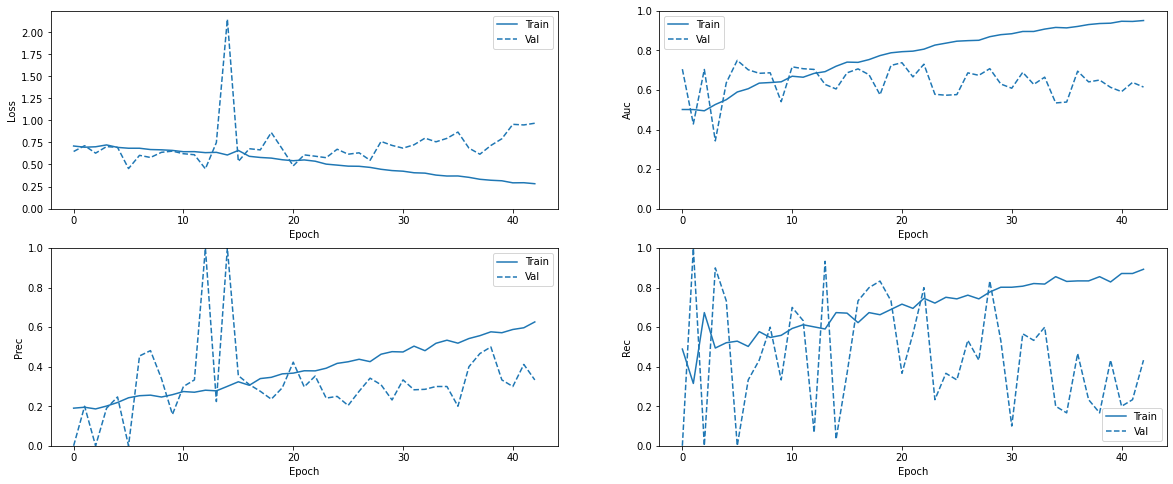


Evaluate kernel regularizers
[mc2] Training with regularization=None
Epoch 1/60
63/63 [==============================] - 8s 103ms/step - loss: 0.6926 - tp: 100.2188 - fp: 455.7656 - tn: 388.0312 - fn: 94.9844 - acc: 0.4868 - prec: 0.1737 - rec: 0.4809 - auc: 0.4842 - val_loss: 0.6438 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 120.0000 - val_fn: 30.0000 - val_acc: 0.8000 - val_prec: 0.0000e+00 - val_rec: 0.0000e+00 - val_auc: 0.6710

Epoch 00001: saving model to mc2_reg_None_model.h5
Epoch 2/60
63/63 [==============================] - 6s 91ms/step - loss: 0.6817 - tp: 57.6406 - fp: 279.9688 - tn: 568.5469 - fn: 132.8438 - acc: 0.6348 - prec: 0.1406 - rec: 0.2664 - auc: 0.4920 - val_loss: 0.6995 - val_tp: 30.0000 - val_fp: 120.0000 - val_tn: 0.0000e+00 - val_fn: 0.0000e+00 - val_acc: 0.2000 - val_prec: 0.2000 - val_rec: 1.0000 - val_auc: 0.5000

Epoch 00002: saving model to mc2_reg_None_model.h5
Epoch 3/60
63/63 [==============================] - 6s 91ms/step - loss: 0.6939 - t

'Best model in val (lower val_loss)'

'epoch: 14'

'val_loss: 0.5199834108352661'

'val_auc: 0.6826388835906982'

'val_prec: 0.5'

'val_rec: 0.20000000298023224'

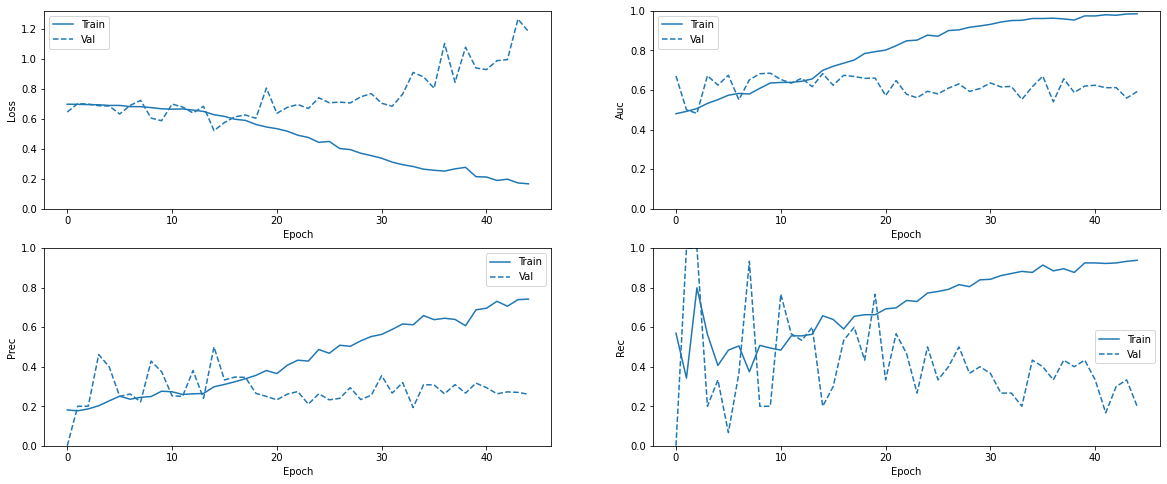

[mc2] Training with regularization=l2_0.001
Epoch 1/60
63/63 [==============================] - 8s 104ms/step - loss: 0.7582 - tp: 123.3750 - fp: 502.5625 - tn: 341.2344 - fn: 71.8281 - acc: 0.4761 - prec: 0.1926 - rec: 0.5806 - auc: 0.5003 - val_loss: 0.6995 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 120.0000 - val_fn: 30.0000 - val_acc: 0.8000 - val_prec: 0.0000e+00 - val_rec: 0.0000e+00 - val_auc: 0.7019

Epoch 00001: saving model to mc2_reg_l2_0.001_model.h5
Epoch 2/60
63/63 [==============================] - 6s 91ms/step - loss: 0.7026 - tp: 121.6094 - fp: 557.9062 - tn: 290.6094 - fn: 68.8750 - acc: 0.4938 - prec: 0.1465 - rec: 0.4966 - auc: 0.4834 - val_loss: 0.7075 - val_tp: 30.0000 - val_fp: 120.0000 - val_tn: 0.0000e+00 - val_fn: 0.0000e+00 - val_acc: 0.2000 - val_prec: 0.2000 - val_rec: 1.0000 - val_auc: 0.5708

Epoch 00002: saving model to mc2_reg_l2_0.001_model.h5
Epoch 3/60
63/63 [==============================] - 6s 92ms/step - loss: 0.7052 - tp: 173.0312 - fp: 

'Best model in val (lower val_loss)'

'epoch: 23'

'val_loss: 0.5920640826225281'

'val_auc: 0.5902777910232544'

'val_prec: 0.20000000298023224'

'val_rec: 0.10000000149011612'

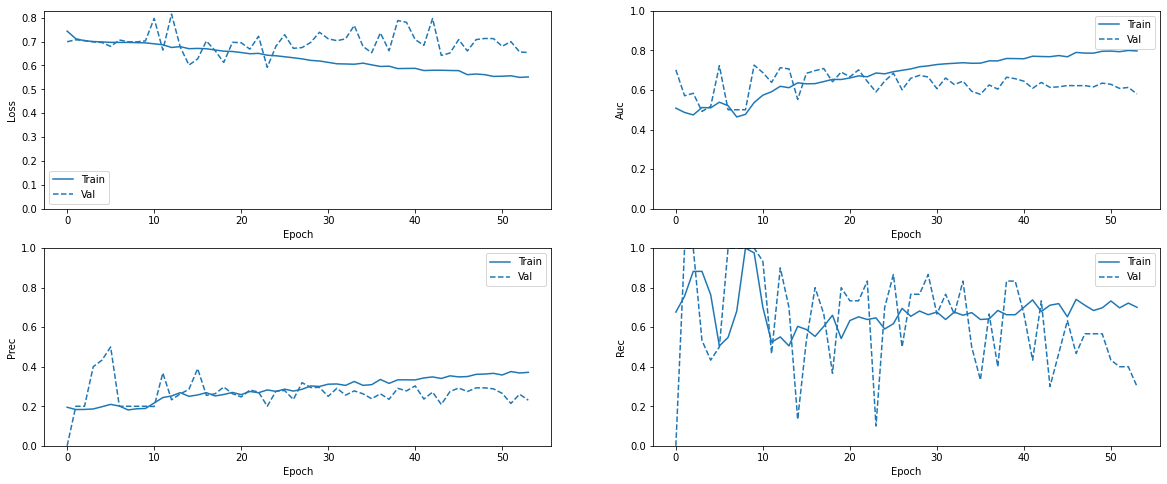

[mc2] Training with regularization=l2_0.01
Epoch 1/60
63/63 [==============================] - 8s 104ms/step - loss: 1.2681 - tp: 110.2188 - fp: 454.8125 - tn: 388.9844 - fn: 84.9844 - acc: 0.5075 - prec: 0.1882 - rec: 0.5112 - auc: 0.5041 - val_loss: 0.7698 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 120.0000 - val_fn: 30.0000 - val_acc: 0.8000 - val_prec: 0.0000e+00 - val_rec: 0.0000e+00 - val_auc: 0.4958

Epoch 00001: saving model to mc2_reg_l2_0.01_model.h5
Epoch 2/60
63/63 [==============================] - 6s 92ms/step - loss: 0.7335 - tp: 88.5312 - fp: 407.6250 - tn: 440.8906 - fn: 101.9531 - acc: 0.5772 - prec: 0.1424 - rec: 0.3690 - auc: 0.4783 - val_loss: 0.7064 - val_tp: 30.0000 - val_fp: 120.0000 - val_tn: 0.0000e+00 - val_fn: 0.0000e+00 - val_acc: 0.2000 - val_prec: 0.2000 - val_rec: 1.0000 - val_auc: 0.5000

Epoch 00002: saving model to mc2_reg_l2_0.01_model.h5
Epoch 3/60
63/63 [==============================] - 6s 92ms/step - loss: 0.7037 - tp: 111.0469 - fp: 501

'Best model in val (lower val_loss)'

'epoch: 44'

'val_loss: 0.5219226479530334'

'val_auc: 0.7294443845748901'

'val_prec: 0.47826087474823'

'val_rec: 0.36666667461395264'

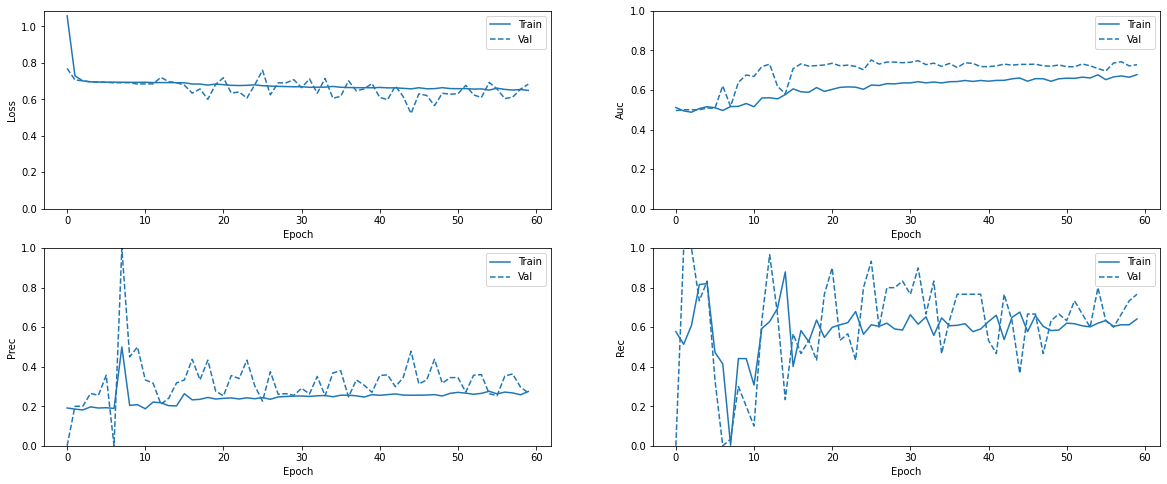

[mc2] Training with regularization=l2_1.0
Epoch 1/60
63/63 [==============================] - 8s 107ms/step - loss: 54.8544 - tp: 72.2969 - fp: 343.1094 - tn: 500.6875 - fn: 122.9062 - acc: 0.5936 - prec: 0.1557 - rec: 0.3001 - auc: 0.4854 - val_loss: 5.0604 - val_tp: 30.0000 - val_fp: 120.0000 - val_tn: 0.0000e+00 - val_fn: 0.0000e+00 - val_acc: 0.2000 - val_prec: 0.2000 - val_rec: 1.0000 - val_auc: 0.5000

Epoch 00001: saving model to mc2_reg_l2_1.0_model.h5
Epoch 2/60
63/63 [==============================] - 6s 94ms/step - loss: 2.9064 - tp: 21.2188 - fp: 133.7812 - tn: 714.7344 - fn: 169.2656 - acc: 0.6229 - prec: 0.1358 - rec: 0.2263 - auc: 0.5000 - val_loss: 0.7480 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 120.0000 - val_fn: 30.0000 - val_acc: 0.8000 - val_prec: 0.0000e+00 - val_rec: 0.0000e+00 - val_auc: 0.5000

Epoch 00002: saving model to mc2_reg_l2_1.0_model.h5
Epoch 3/60
63/63 [==============================] - 6s 94ms/step - loss: 0.7175 - tp: 55.8438 - fp: 280.65

'Best model in val (lower val_loss)'

'epoch: 10'

'val_loss: 0.6922895908355713'

'val_auc: 0.5'

'val_prec: 0.0'

'val_rec: 0.0'

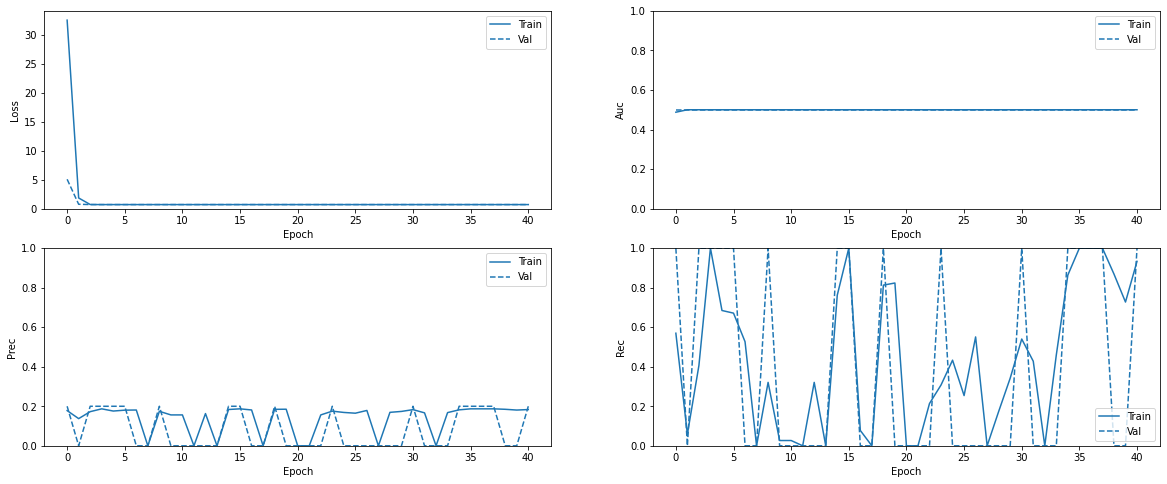

[mc2] Training with regularization=l2_1.5
Epoch 1/60
63/63 [==============================] - 8s 107ms/step - loss: 81.9317 - tp: 81.3906 - fp: 353.3281 - tn: 490.4688 - fn: 113.8125 - acc: 0.5958 - prec: 0.1694 - rec: 0.3328 - auc: 0.4919 - val_loss: 7.2440 - val_tp: 30.0000 - val_fp: 120.0000 - val_tn: 0.0000e+00 - val_fn: 0.0000e+00 - val_acc: 0.2000 - val_prec: 0.2000 - val_rec: 1.0000 - val_auc: 0.5000

Epoch 00001: saving model to mc2_reg_l2_1.5_model.h5
Epoch 2/60
63/63 [==============================] - 6s 94ms/step - loss: 4.0195 - tp: 16.5312 - fp: 109.4062 - tn: 739.1094 - fn: 173.9531 - acc: 0.6502 - prec: 0.1304 - rec: 0.1891 - auc: 0.4802 - val_loss: 0.7759 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 120.0000 - val_fn: 30.0000 - val_acc: 0.8000 - val_prec: 0.0000e+00 - val_rec: 0.0000e+00 - val_auc: 0.5000

Epoch 00002: saving model to mc2_reg_l2_1.5_model.h5
Epoch 3/60
63/63 [==============================] - 6s 94ms/step - loss: 0.7294 - tp: 88.1875 - fp: 449.31

'Best model in val (lower val_loss)'

'epoch: 10'

'val_loss: 0.691970705986023'

'val_auc: 0.5'

'val_prec: 0.0'

'val_rec: 0.0'

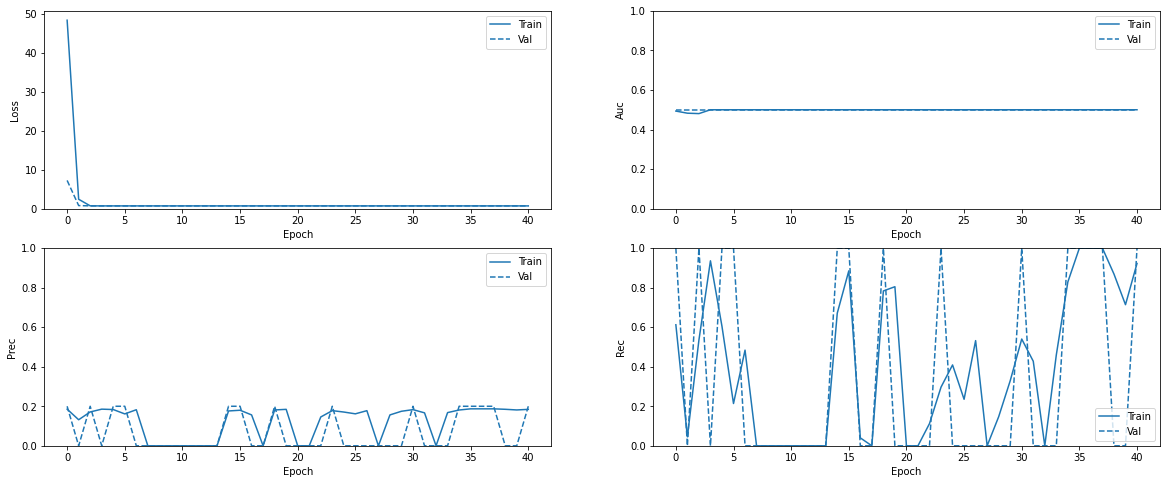

In [13]:
# Model candidate 2

# Variation of baseline model with bigger polling kernel sizes
# and bigger initial CNN kernel size.

def model_mc2(cnn_activation="relu", kernel_regularizer=None):
  return tf.keras.Sequential([
      layers.experimental.preprocessing.Rescaling(scale=1./255),
      layers.Conv2D(64, 7, activation=cnn_activation,
                    kernel_regularizer=kernel_regularizer),
      layers.MaxPooling2D((3,3)),
      layers.Conv2D(32, 3, activation=cnn_activation,
                    kernel_regularizer=kernel_regularizer),
      layers.MaxPooling2D((3,3)),
      layers.Conv2D(64, 3, activation=cnn_activation,
                    kernel_regularizer=kernel_regularizer),
      layers.MaxPooling2D((3,3)),
      layers.Flatten(),
      layers.Dense(1, activation='sigmoid')
    ])

md = model_mc2()
md.build((None, 299, 299, 3))
display(md.summary())
mc2_hist_acts, mc2_hist_opts, mc2_hist_regs = do_experiment(model_mc2, tag="mc2") 

> Quais são as suas impressões? O resultado melhorou em relação ao baseline? (1-2 parágrafos)

Some explored changes to the models improved results. The first model created to compare against the baseline, model candidate 1 (mc1), has `78k` parameters due to two more CNN layers but bigger convolutional filters (thus reducing feature maps). The second model has `52k` parameters and explores the use of bigger polling kernel sizes when compared with mc1.

The most interesting improvement due to configuration change was the use of `adagrad` optimizer that improved results for both mc1 and mc2, achieving both about `0.75` AUC. When compared to their results when using `adam` (the same optimizer used in the baseline model with `0.47` AUC), mc1 achieved `0.67` AUC and mc2 `0.73` AUC. Experiments with activation functions and regularizers didn't show considerable or interesting improvements when compared with the said use of `adagrad`. There were some good results with some configurations but the improvements were not consistent with mc1 and mc2 like the use of `adagrad` showed.

3. (3,0 pts) Escolha uma arquitetura cuja implementação e pesos pré-treinados na ImageNet estejam disponíveis como extratora de features. 

- (1,5 pts) Inicialmente, descarte a saída original e congele suas as camadas. Adicione uma nova camada de saída com o número de classes adequadas para este problema.


In [14]:
input_shape = (img_width, img_height, channels)
mobilenetv2 = tf.keras.applications.MobileNetV2(input_shape=input_shape,
                                                include_top=False,
                                                weights='imagenet')

9412608/9406464 [==============================] - 0s 0us/step


In [15]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input
mobilenetv2.trainable = False
tl_global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
prediction_layer = tf.keras.layers.Dense(1, activation='sigmoid')

inputs = tf.keras.Input(shape=input_shape)
x = preprocess_input(inputs)
x = mobilenetv2(x, training=False)
x = tl_global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
tl_model = tf.keras.Model(inputs, outputs)

tl_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 299, 299, 3)]     0         
_________________________________________________________________
tf.math.truediv (TFOpLambda) (None, 299, 299, 3)       0         
_________________________________________________________________
tf.math.subtract (TFOpLambda (None, 299, 299, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_224 (Functi (None, 10, 10, 1280)      2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0         
_________________________________________________________________
dense_25 (Dense)             (None, 1)                 1281  

In [16]:
def train_tranfer_learning(model, loss="binary_crossentropy",
                           opt=tf.keras.optimizers.Adam(lr=0.0001),
                           learning_rate=0.001, epochs=60, patience=30,
                           tag="transfer_learning", use_classweights=True,
                           compile=True):
  """ Transfer learning train function. """
  mc = tf.keras.callbacks.ModelCheckpoint(f'{tag}_model.h5', monitor='val_loss', mode='min', verbose=1)
  if patience:
    es = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                          mode='min',
                                          verbose=1,
                                          patience=patience,
                                          restore_best_weights=True)
    cb_list = [mc, es]
  else:
    cb_list = [mc]

  metrics = [
        keras.metrics.TruePositives(name='tp'),
        keras.metrics.FalsePositives(name='fp'),
        keras.metrics.TrueNegatives(name='tn'),
        keras.metrics.FalseNegatives(name='fn'), 
        keras.metrics.BinaryAccuracy(name='acc'),
        keras.metrics.Precision(name='prec'),
        keras.metrics.Recall(name='rec'),
        keras.metrics.AUC(name='auc'),
  ]

  if compile:
    model.compile(
      optimizer=opt,
      loss=loss,
      metrics=metrics)

  if use_classweights:
    history = model.fit(x_train, y_train, validation_data=(x_val, y_val),
                        epochs=epochs,
                        class_weight=class_weights,
                        callbacks=cb_list)
  else:
    history = model.fit(x_train, y_train, validation_data=(x_val, y_val),
                        epochs=epochs,
                        callbacks=cb_list)
  return history

Epoch 1/60
63/63 [==============================] - 10s 114ms/step - loss: 0.7398 - tp: 113.5938 - fp: 457.9219 - tn: 385.8750 - fn: 81.6094 - acc: 0.4663 - prec: 0.1991 - rec: 0.6333 - auc: 0.5261 - val_loss: 0.6764 - val_tp: 12.0000 - val_fp: 45.0000 - val_tn: 75.0000 - val_fn: 18.0000 - val_acc: 0.5800 - val_prec: 0.2105 - val_rec: 0.4000 - val_auc: 0.5379

Epoch 00001: saving model to transfer_learning_model.h5
Epoch 2/60
63/63 [==============================] - 5s 86ms/step - loss: 0.7024 - tp: 102.4688 - fp: 384.8281 - tn: 463.6875 - fn: 88.0156 - acc: 0.5408 - prec: 0.2023 - rec: 0.5437 - auc: 0.5634 - val_loss: 0.6590 - val_tp: 13.0000 - val_fp: 39.0000 - val_tn: 81.0000 - val_fn: 17.0000 - val_acc: 0.6267 - val_prec: 0.2500 - val_rec: 0.4333 - val_auc: 0.5789

Epoch 00002: saving model to transfer_learning_model.h5
Epoch 3/60
63/63 [==============================] - 5s 86ms/step - loss: 0.7053 - tp: 117.8750 - fp: 397.3906 - tn: 447.6719 - fn: 76.0625 - acc: 0.5478 - prec: 0.2

'Best model in val (lower val_loss)'

'epoch: 46'

'val_loss: 0.47965097427368164'

'val_auc: 0.7538889050483704'

'val_prec: 0.4444444477558136'

'val_rec: 0.5333333611488342'

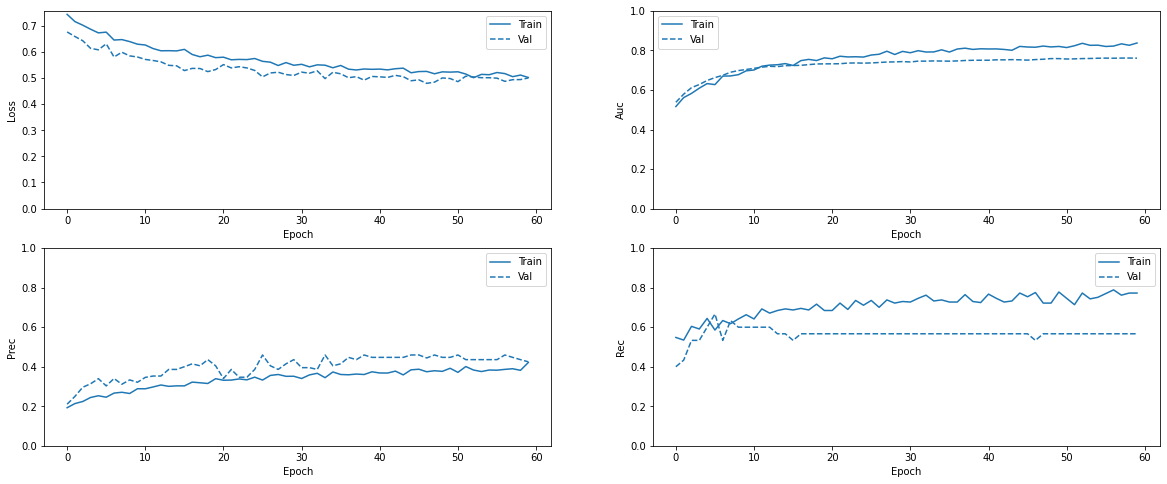

In [17]:
# train transfer learning model

hist_transfer_learning = train_tranfer_learning(tl_model)
plot_metrics(hist_transfer_learning)

> Quais são as suas impressões? O resultado melhorou em relação à questão anterior? Como foi o tempo de treinamento? Houve overfitting? (1-2 parágrafos) 

Results improved using `mobilenetv2` for feature extraction achieving AUC `0.75`. The training behavior looks good and better than from previous models, showing that if trained for more epochs the model would probably improve both for the training and validation set, while for the previous models the majority of them showed an overfitting behavior when comparing training and validation losses.

- (1,5 pts) Descongele as camadas da rede extratora de features e realize o fine-tuning da rede, continuando o treinamento.

Epoch 1/60
63/63 [==============================] - 5s 87ms/step - loss: 0.5069 - tp: 295.0000 - fp: 460.0000 - tn: 1166.0000 - fn: 79.0000 - acc: 0.7305 - prec: 0.3907 - rec: 0.7888 - auc: 0.8313 - val_loss: 0.4861 - val_tp: 17.0000 - val_fp: 20.0000 - val_tn: 100.0000 - val_fn: 13.0000 - val_acc: 0.7800 - val_prec: 0.4595 - val_rec: 0.5667 - val_auc: 0.7629

Epoch 00001: saving model to transfer_learning2_model.h5
Epoch 2/60
63/63 [==============================] - 5s 86ms/step - loss: 0.5041 - tp: 281.0000 - fp: 436.0000 - tn: 1190.0000 - fn: 93.0000 - acc: 0.7355 - prec: 0.3919 - rec: 0.7513 - auc: 0.8329 - val_loss: 0.4948 - val_tp: 17.0000 - val_fp: 22.0000 - val_tn: 98.0000 - val_fn: 13.0000 - val_acc: 0.7667 - val_prec: 0.4359 - val_rec: 0.5667 - val_auc: 0.7621

Epoch 00002: saving model to transfer_learning2_model.h5
Epoch 3/60
63/63 [==============================] - 5s 86ms/step - loss: 0.5021 - tp: 298.0000 - fp: 450.0000 - tn: 1176.0000 - fn: 76.0000 - acc: 0.7370 - prec:

'Best model in val (lower val_loss)'

'epoch: 47'

'val_loss: 0.4535471498966217'

'val_auc: 0.7752777338027954'

'val_prec: 0.4545454680919647'

'val_rec: 0.5'

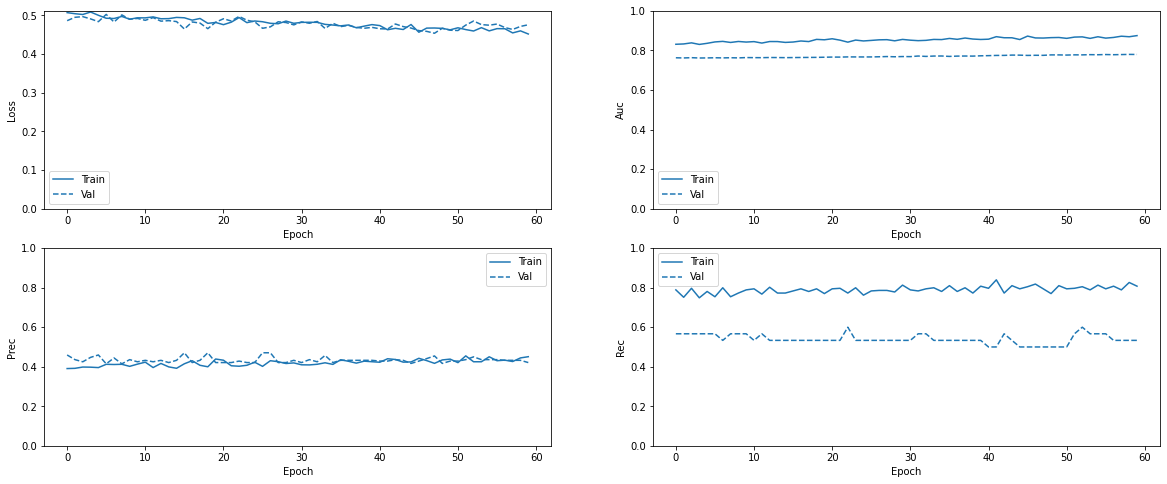

In [18]:
tl_model.trainable = True
hist2_transfer_learning = train_tranfer_learning(tl_model, tag="transfer_learning2", compile=False)
plot_metrics(hist2_transfer_learning)

> Quais são as suas impressões? O resultado melhorou em relação à questão anterior? Como foi o tempo de treinamento? Houve overfitting? (1-2 parágrafos)

After unfreezing layers and continuing the training for more `60` epochs results improved from `0.75` AUC to `0.77` AUC in the validation dataset at epoch `47`. There seems to be an increase in validation loss after epoch 47 to 60 but to be sure that the model might not be able to improve more it would be best to let the training go for a couple more epochs. There definitively happened a fine-tuning to this dataset with an increase of `0.02` AUC.

4. (0,5 pts) Plote os gráficos da função de loss × número de épocas, para o treino e validação de cada modelo gerado. Houve overfitting?





In [19]:
# Function for experiment metrics comparison

def evaluate_models(hist_acts, hist_opts, hist_regs, tag="model"):
  """Evaluate models by history objects from training."""
  col_names = ["Method", "Epoch", "Accuracy", "AUC", "Precision", "Recall"]

  def pack_metrics_df(methods, hist_list):
    df = pd.DataFrame(columns=col_names)
    for method, hist in zip(methods, hist_list):
      idx = np.argmin(hist.history["val_loss"])
      chosen_metrics = \
        pd.DataFrame([[method, hist.epoch[idx], hist.history["val_acc"][idx],
                       hist.history["val_auc"][idx], hist.history["val_prec"][idx],
                       hist.history["val_rec"][idx]]], columns=col_names)
      df = pd.concat([df, chosen_metrics])
      df = df.reset_index(drop=True)
    return df

  df_acts = pack_metrics_df(acts, hist_acts)
  df_opts = pack_metrics_df(optimizers_str, hist_opts)
  df_regs = pack_metrics_df(regularization_str, hist_regs)
  
  mpl.rcParams['figure.figsize'] = (20, 8)
  colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
  
  def plot_models_hist(methods, hist_list):
    metrics = ['loss', 'auc', 'prec', 'rec']
    for n, metric in enumerate(metrics):
      name = metric.replace("_"," ").capitalize()
      plt.subplot(2,2,n+1)
      for i, method, hist in zip(range(len(methods)), methods, hist_list):
        plt.plot(hist.epoch, hist.history[metric], color=colors[i], label=f'{method} Train')
        plt.plot(hist.epoch, hist.history['val_'+metric],
                color=colors[i], linestyle="--", label=f'{method} Val')
        plt.xlabel('Epoch')
        plt.ylabel(name)
        if metric == 'loss':
          plt.ylim([0, plt.ylim()[1]])
        elif metric == 'auc':
          plt.ylim([0,1])
        else:
          plt.ylim([0,1])
        plt.legend()
    plt.show() 

  print("\n" + tag + " activation functions")
  display(df_acts)
  plot_models_hist(acts, hist_acts)
  print("\n" + tag + " optimizers")
  display(df_opts)
  plot_models_hist(optimizers_str, hist_opts)
  print("\n" + tag + " convolution layers kernel initializers")
  display(df_regs)
  plot_models_hist(regularization_str, hist_regs)


baseline model


'Best model in val (lower val_loss)'

'epoch: 6'

'val_loss: 0.6882274150848389'

'val_auc: 0.47138887643814087'

'val_prec: 0.0'

'val_rec: 0.0'

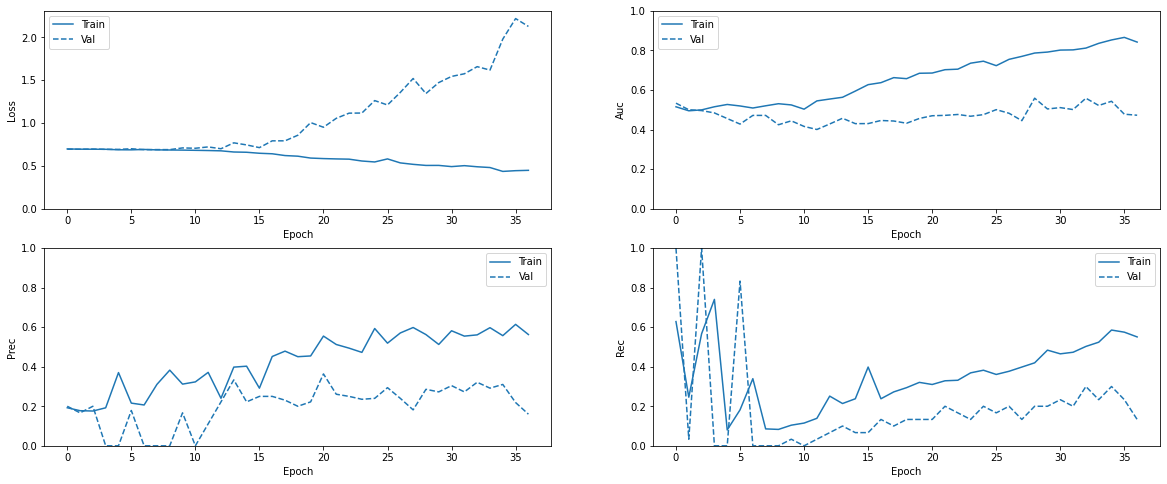

mc1 configurations

Model mc1 activation functions


Method Epoch  Accuracy       AUC  Precision    Recall
0   relu    15  0.740000  0.625139   0.363636  0.400000
1    elu     2  0.766667  0.588055   0.142857  0.033333
2   tanh    12  0.740000  0.770417   0.390244  0.533333

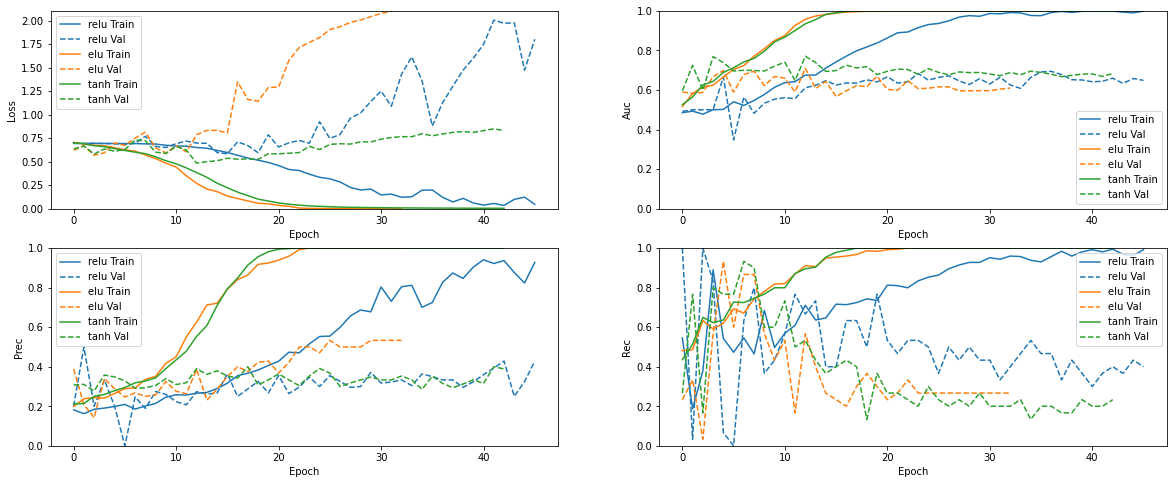


Model mc1 optimizers


Method Epoch  Accuracy       AUC  Precision    Recall
0     adam     2  0.733333  0.673750   0.343750  0.366667
1  adagrad    58  0.693333  0.748333   0.370968  0.766667
2  RMSprop    12  0.786667  0.744167   0.464286  0.433333

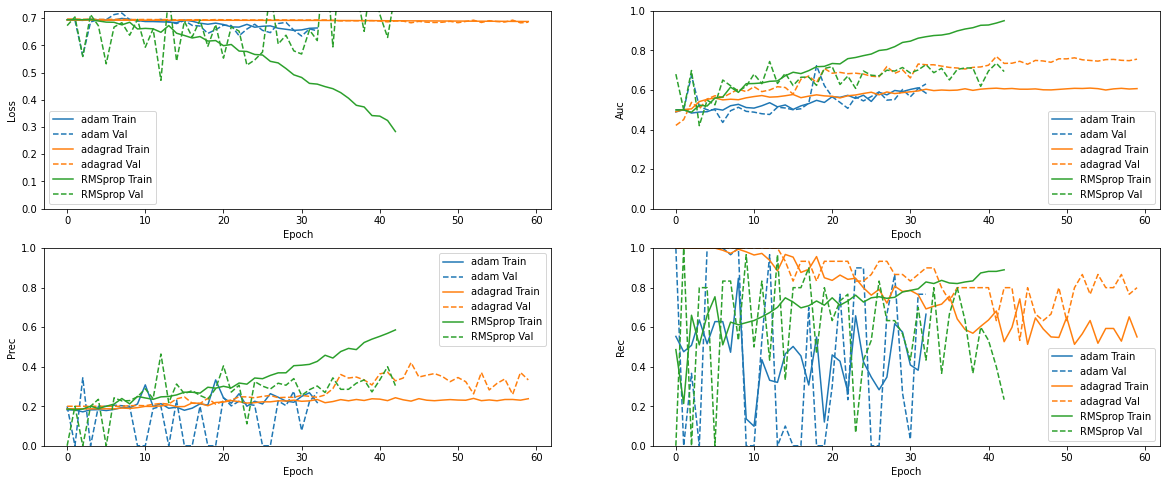


Model mc1 convolution layers kernel initializers


Method Epoch  Accuracy     AUC  Precision  Recall
0      None    23  0.766667  0.6775   0.413793     0.4
1  l2_0.001    10  0.800000  0.5000   0.000000     0.0
2   l2_0.01    10  0.800000  0.5000   0.000000     0.0
3    l2_1.0     6  0.800000  0.5000   0.000000     0.0
4    l2_1.5     6  0.800000  0.5000   0.000000     0.0

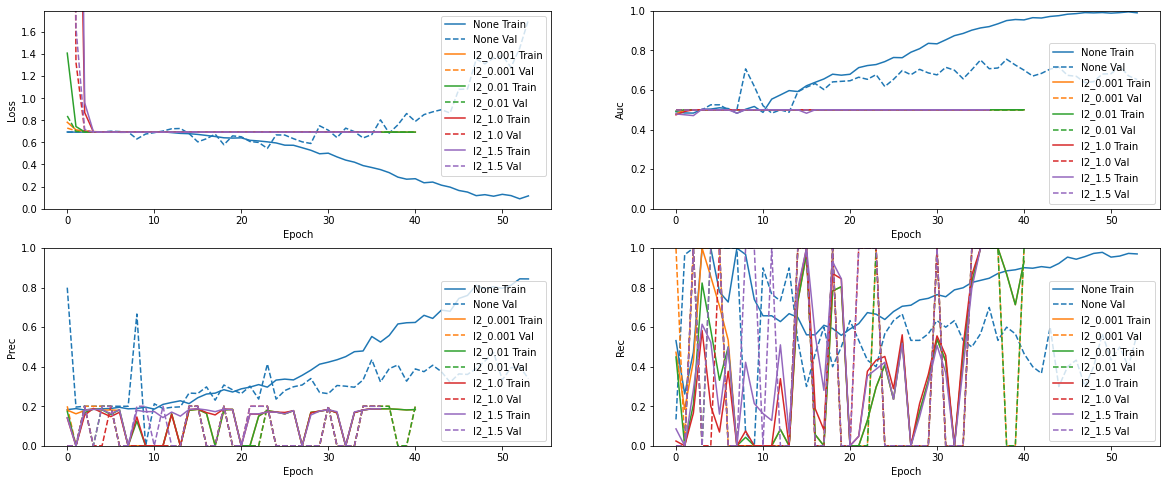

mc2 configurations

Model mc2 activation functions


Method Epoch  Accuracy       AUC  Precision    Recall
0   relu    28  0.793333  0.566389   0.461538  0.200000
1    elu     9  0.746667  0.741806   0.382353  0.433333
2   tanh     5  0.800000  0.628611   0.000000  0.000000

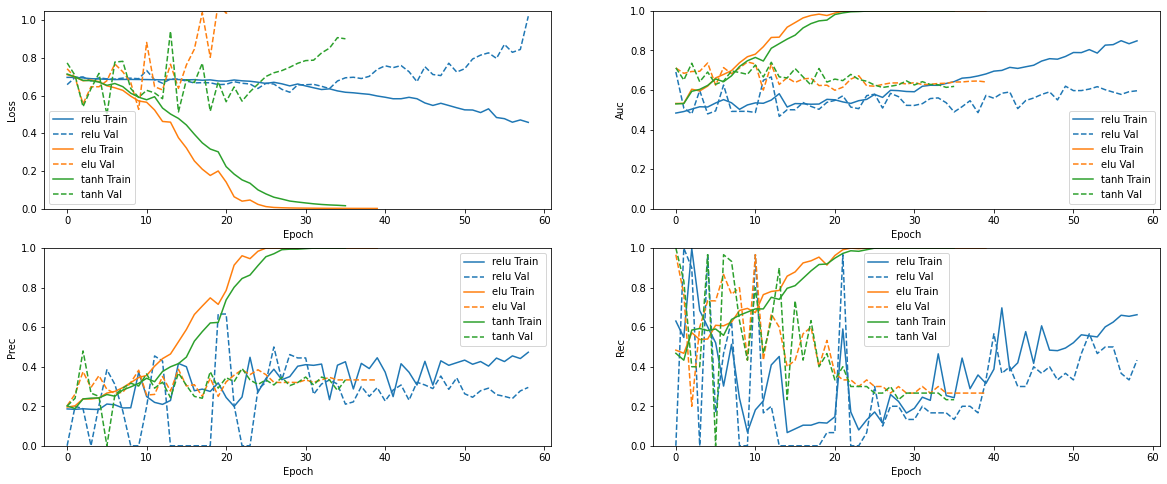


Model mc2 optimizers


Method Epoch  Accuracy       AUC  Precision    Recall
0     adam    12  0.753333  0.733750   0.387097  0.400000
1  adagrad    44  0.820000  0.754583   0.571429  0.400000
2  RMSprop    12  0.813333  0.704028   1.000000  0.066667

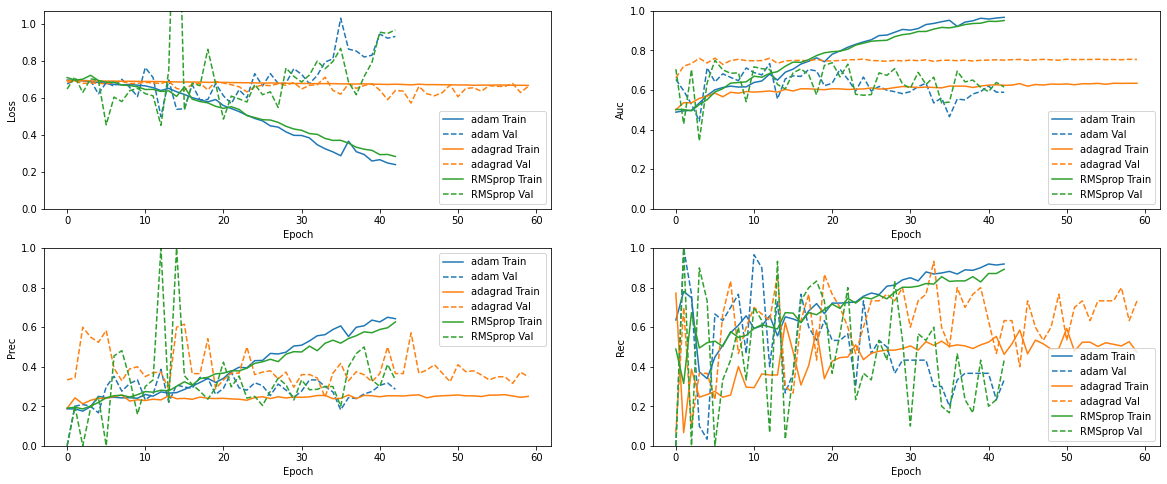


Model mc2 convolution layers kernel initializers


Method Epoch  Accuracy       AUC  Precision    Recall
0      None    14  0.800000  0.682639   0.500000  0.200000
1  l2_0.001    23  0.740000  0.590278   0.200000  0.100000
2   l2_0.01    44  0.793333  0.729444   0.478261  0.366667
3    l2_1.0    10  0.800000  0.500000   0.000000  0.000000
4    l2_1.5    10  0.800000  0.500000   0.000000  0.000000

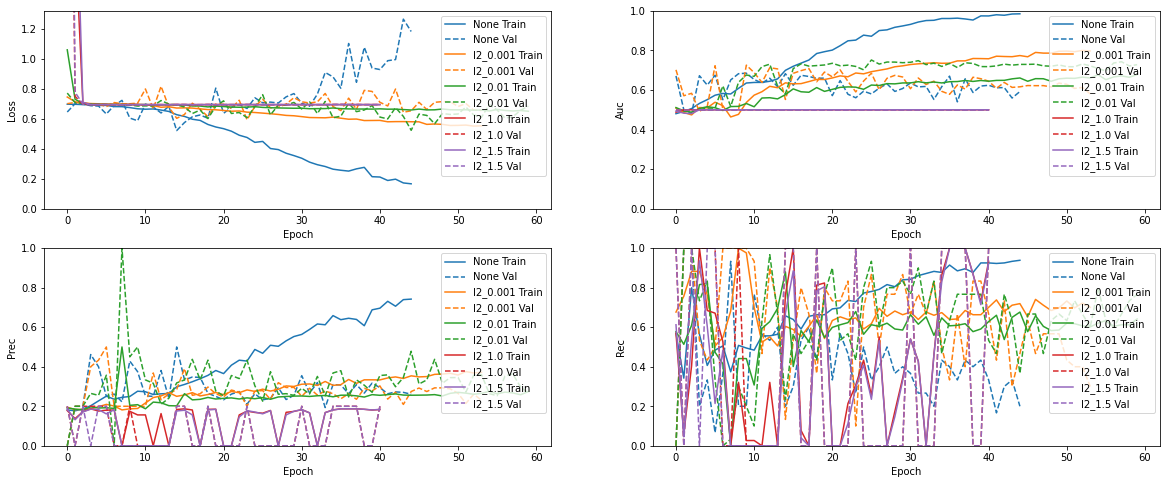

transfer learning with frozen layers


'Best model in val (lower val_loss)'

'epoch: 46'

'val_loss: 0.47965097427368164'

'val_auc: 0.7538889050483704'

'val_prec: 0.4444444477558136'

'val_rec: 0.5333333611488342'

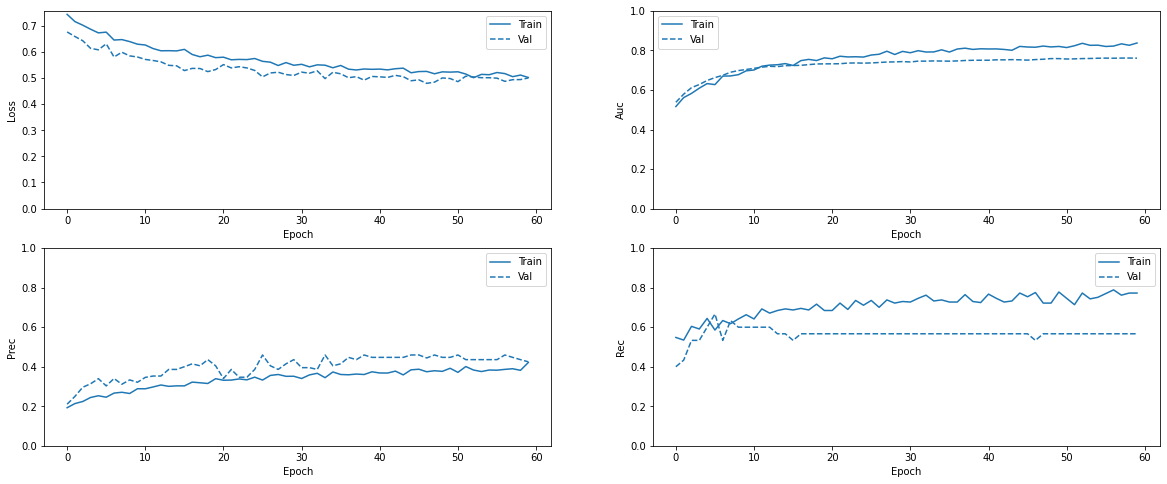

transfer learning after unfrozing layers layers


'Best model in val (lower val_loss)'

'epoch: 47'

'val_loss: 0.4535471498966217'

'val_auc: 0.7752777338027954'

'val_prec: 0.4545454680919647'

'val_rec: 0.5'

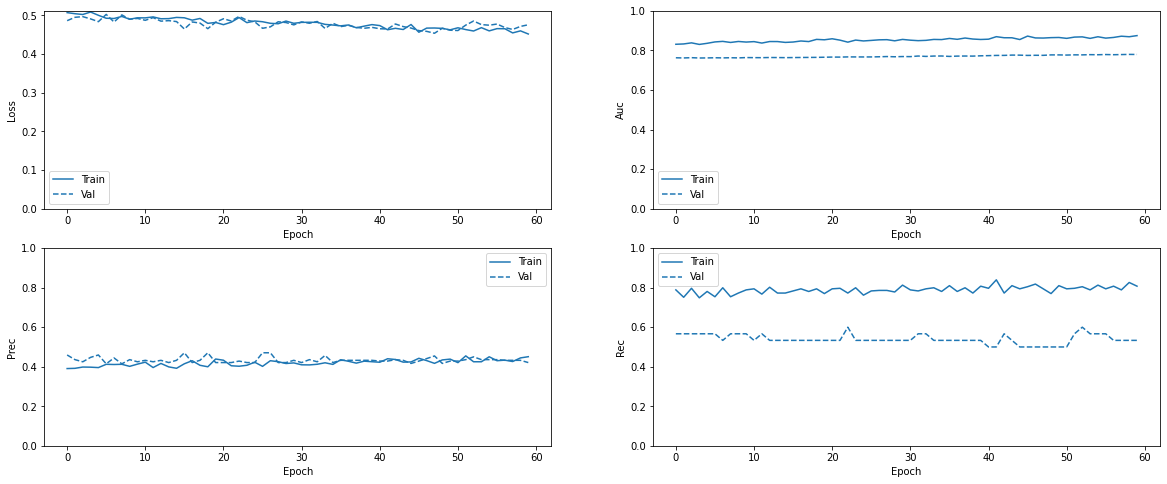

In [20]:
print("baseline model")
plot_metrics(baseline_history)
print("mc1 configurations")
evaluate_models(mc1_hist_acts, mc1_hist_opts, mc1_hist_regs, tag="Model mc1")
print("mc2 configurations")
evaluate_models(mc2_hist_acts, mc2_hist_opts, mc2_hist_regs, tag="Model mc2")
print("transfer learning with frozen layers")
plot_metrics(hist_transfer_learning)
print("transfer learning after unfrozing layers layers")
plot_metrics(hist2_transfer_learning)

> Quais são as suas impressões? Houve overfitting? (1-2 parágrafos)

Metrics comparisons are of models obtained for each configuration in the training epoch that had the lowest value for validation loss. With exception of the transfer learning approach, it's possible to say that for the majority of configurations after a certain quantity of training epochs the models started to overfit to the training data. The found best model was the transfer learning approach after the unfreeze of layers for fine-tuning.


5. (0,5 pts) Avalie o melhor modelo no conjunto de teste. Obs: Avaliação no conjunto de teste só pode ser executada uma única vez.

In [21]:
model = tf.keras.models.load_model("transfer_learning2_model.h5")
val_results = list(zip(model.metrics_names, model.evaluate(x_val, y_val)))
print("validation results:")
[print(each) for each in val_results];

test_results = list(zip(model.metrics_names, model.evaluate(x_test, y_test)))
print("test results:")
[print(each) for each in test_results];

5/5 [==============================] - 2s 77ms/step - loss: 0.4755 - tp: 16.0000 - fp: 22.0000 - tn: 98.0000 - fn: 14.0000 - acc: 0.7600 - prec: 0.4211 - rec: 0.5333 - auc: 0.7797
validation results:
('loss', 0.47552186250686646)
('tp', 16.0)
('fp', 22.0)
('tn', 98.0)
('fn', 14.0)
('acc', 0.7599999904632568)
('prec', 0.42105263471603394)
('rec', 0.5333333611488342)
('auc', 0.7797222137451172)
19/19 [==============================] - 2s 94ms/step - loss: 0.5840 - tp: 72.0000 - fp: 145.0000 - tn: 338.0000 - fn: 45.0000 - acc: 0.6833 - prec: 0.3318 - rec: 0.6154 - auc: 0.7291
test results:
('loss', 0.5840469002723694)
('tp', 72.0)
('fp', 145.0)
('tn', 338.0)
('fn', 45.0)
('acc', 0.6833333373069763)
('prec', 0.3317972421646118)
('rec', 0.6153846383094788)
('auc', 0.729123592376709)


6. (2,0 pts) Elabore uma conclusão discutindo os experimentos. 

Out of the created experiments and uses of different CNN configurations, the best and more consistent results were found for the transfer learning approaches. With the training loss curves it's possible to see that the models trained from scratch presented a tendency of overfitting to the training data after just some epochs, and thus increasing error for validation data, while in the transfer learning approach loss curves had a better behavior by improving both in training and validation losses by way longer epochs. This behavior is probably related to the size and diversity of the available dataset, since the chosen transfer learning model was trained in imagenet.

The best model obtained from the transfer learning approach by loading `mobilenetv2` had a performance of `0.78` AUC for validation and `0.73` in the test set. It can be said that the result is somewhat acceptable depending on the application/analysis but it still is a long way from a competition winning result. For a better model, it would be better to have a data augmentation pipeline and possibly a model with more parameters. Data augmentation was tried in this work but problems were encountered with the TensorFlow library (use of generators in the model.Sequential.fit() method) that caused memory leaks in the environment and thus was abandoned due to this project deadline.

In conclusion, this project contributed to increasing familiarity with deep learning methods, frameworks, common occurring nuisances that can be found while designing these solutions. It's important to have experience with the adequate tools and necessary processes to conduct experiments, as development time can be easily more demanding for tasks that circles the design of machine learning algorithms, such as data analysis, data cleaning, programming process pipelines, debug of frameworks/library problems and so on; because without the proper affinity/organization deep learning can become a difficult task.

In [24]:
while True:pass

KeyboardInterrupt: ignored